## **1.1.Завантажимо набір даних IKEA.**

Щоб почати працювати з набором даних спочатку завантажуємо необхідні бібліотеки

In [115]:
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import warnings

warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
pd.options.display.float_format = '{:.5f}'.format
%matplotlib inline
sns.set('notebook')

In [260]:
from scipy import stats
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor
import xgboost as xgb
from xgboost import XGBRegressor

from scipy.stats import ttest_ind, mannwhitneyu, normaltest
from scipy.stats import shapiro
from scipy.stats import kruskal

Завантажимо файл

In [117]:
def download_file(url, filename):
    if os.path.exists(filename):
        print('File already downloaded.')
    else:
        response = requests.get(url)
        if response.status_code == 200:
            with open(filename, 'wb') as f:
                f.write(response.content)
            print('File downloaded successfully.')
        else:
            print('Download error.')

In [118]:
def check_status_code(req):
    match req.status_code:
        case 200:
            print('All ok')
        case 404:
            raise Exception('Error connect')
        case _ as e:
            print(f'Unknown error: {e}')

In [119]:
URL = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv'
filename = 'ikea.csv'

req = requests.get(URL)
check_status_code(req)

download_file(URL, filename)

All ok
File already downloaded.


Читаємо файл

In [120]:
df = pd.read_csv(filename, sep = ',')

## **1.2.Початковий огляд даних та попередня обробка.**

In [121]:
df.info()# короткий опис набору даних

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3694 non-null   int64  
 1   item_id            3694 non-null   int64  
 2   name               3694 non-null   object 
 3   category           3694 non-null   object 
 4   price              3694 non-null   float64
 5   old_price          3694 non-null   object 
 6   sellable_online    3694 non-null   bool   
 7   link               3694 non-null   object 
 8   other_colors       3694 non-null   object 
 9   short_description  3694 non-null   object 
 10  designer           3694 non-null   object 
 11  depth              2231 non-null   float64
 12  height             2706 non-null   float64
 13  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 378.9+ KB


>**item_id** - unique number for item. Type: int64  
> **name** - name of item. Type: int64  
> **category** - category name.  Type: int64  
> **price** - price of item.  Type: float64     
> **old_price** - have or not old_price. Type: object   
> **sellable_online** - item in online market. Type: bool   
> **link** - link on item in market. Type: object   
> **other_colors** - available or not different color of item. Type: object   
> **short_description** - short info about item . Type: object   
> **designer** - designer name. Type: object    
> **depth**   - depth of item. Type: float64  
> **height** - height of item. Type: float64  
> **width**  - width of item. Type:  float64    

In [122]:
df.shape #розмірність набору даних

(3694, 14)

In [123]:
df.head() #перші 5 рядків

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,0,90420332,FREKVENS,Bar furniture,265.00000,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.00000,51.00000
1,1,368814,NORDVIKEN,Bar furniture,995.00000,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.00000,80.00000
2,2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.00000,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,3,80155205,STIG,Bar furniture,69.00000,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.00000,100.00000,60.00000
4,4,30180504,NORBERG,Bar furniture,225.00000,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.00000,43.00000,74.00000


In [124]:
df.tail()  #останні 5 рядків

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
3689,3689,99157902,ELVARLI,Wardrobes,750.00000,SR 820,True,https://www.ikea.com/sa/en/p/elvarli-1-section...,No,"1 section, 92x51x222-350 cm",Ehlén Johansson,50.00000,NaN,91.00000
3690,3690,9158152,ELVARLI,Wardrobes,1572.00000,"SR 1,755",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 135x51x222-350 cm",Ehlén Johansson,50.00000,NaN,135.00000
3691,3691,59157541,ELVARLI,Wardrobes,924.00000,"SR 1,050",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 175x51x222-350 cm",Ehlén Johansson,50.00000,NaN,175.00000
3692,3692,89157573,ELVARLI,Wardrobes,2745.00000,"SR 3,130",True,https://www.ikea.com/sa/en/p/elvarli-3-section...,No,"3 sections, 178x51x222-350 cm",Ehlén Johansson,50.00000,NaN,178.00000
3693,3693,69157376,ELVARLI,Wardrobes,1231.00000,"SR 1,535",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 175x51x222-350 cm",Ehlén Johansson,50.00000,NaN,175.00000


In [125]:
df.sample(5)     #рандомні 5 рядків

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
1615,1615,60403602,MALM,Chests of drawers & drawer units,495.00000,No old price,True,https://www.ikea.com/sa/en/p/malm-chest-of-6-d...,Yes,"Chest of 6 drawers, 80x123 cm",IKEA of Sweden,48.00000,123.00000,80.00000
3390,3390,80338413,BAGGANÄS,TV & media furniture,35.00000,No old price,True,https://www.ikea.com/sa/en/p/bagganaes-handle-...,Yes,"Handle, 143 mm",H Preutz/A Fredriksson,31.00000,NaN,9.00000
244,244,50201534,GONATT,Beds,1095.00000,No old price,True,https://www.ikea.com/sa/en/p/gonatt-cot-white-...,No,"Cot, 60x120 cm",J Asshoff/H Brogård,NaN,103.00000,66.00000
366,366,334536,EKET,Bookcases & shelving units,235.00000,No old price,True,https://www.ikea.com/sa/en/p/eket-cabinet-with...,Yes,"Cabinet with 4 compartments, ...",Jon Karlsson,35.00000,70.00000,70.00000
2930,2930,40348664,YPPERLIG,Tables & desks,275.00000,No old price,True,https://www.ikea.com/sa/en/p/ypperlig-children...,No,"Children's table, 74x62 cm",HAY,NaN,51.00000,62.00000


In [126]:
df.describe()  #коротка статистика даних

,Unnamed: 0,item_id,price,depth,height,width
count,3694.00000,3694.00000,3694.00000,2231.00000,2706.00000,3105.00000
mean,1846.50000,48632396.78993,1078.20842,54.37920,101.67997,104.47085
std,1066.51027,28887094.09944,1374.65249,29.95835,61.09759,71.13377
min,0.00000,58487.00000,3.00000,1.00000,1.00000,1.00000
25%,923.25000,20390574.00000,180.90000,38.00000,67.00000,60.00000
50%,1846.50000,49288078.00000,544.70000,47.00000,83.00000,80.00000
75%,2769.75000,70403572.75000,1429.50000,60.00000,124.00000,140.00000
max,3693.00000,99932615.00000,9585.00000,257.00000,700.00000,420.00000


In [127]:
df.columns    #перевіряємо які стовпці містить набір даних

Index(['Unnamed: 0', 'item_id', 'name', 'category', 'price', 'old_price',
       'sellable_online', 'link', 'other_colors', 'short_description',
       'designer', 'depth', 'height', 'width'],
      dtype='object')

In [128]:
df['Unnamed: 0'].unique()     # подивимось на унікальні значення стовчика

array([   0,    1,    2, ..., 3691, 3692, 3693])

Бачимо, що цей стовпець дублює індекси, тому видалимо його

In [129]:
df = df.drop(['Unnamed: 0'], axis= 1)
df.columns #перевіримо після видалення

Index(['item_id', 'name', 'category', 'price', 'old_price', 'sellable_online',
       'link', 'other_colors', 'short_description', 'designer', 'depth',
       'height', 'width'],
      dtype='object')

In [130]:
df['item_id'].unique()

array([90420332,   368814,  9333523, ...,  9158152, 59157541, 89157573])

Перевіряємо набір даних на дублі

In [131]:
df['item_id'].duplicated().sum()

732

Маємо значну кількість дублікатів, що може суттєво вплинути на аналіз даних, та результати машинного навчання. Тому видалимо їх.

In [132]:
df = df.drop_duplicates(['item_id']).reset_index(drop=True)

Робимо перевірку після видалення

In [133]:
df.shape

(2962, 13)

In [134]:
df['link'].duplicated().sum()

0

Стовпчики 'item_id'  та 'link' нам не потрібні для аналізу, тому видалимо їх

In [135]:
df = df.drop(['item_id','link'], axis= 1)
df.columns #перевіримо після видалення

Index(['name', 'category', 'price', 'old_price', 'sellable_online',
       'other_colors', 'short_description', 'designer', 'depth', 'height',
       'width'],
      dtype='object')

In [136]:
df['designer'].unique()

array(['Nicholai Wiig Hansen', 'Francis Cayouette', 'Henrik Preutz',
       'Marcus Arvonen', 'Carina Bengs', 'K Hagberg/M Hagberg',
       'Sarah Fager', 'Ehlén Johansson', 'Nike Karlsson',
       'Maja Ganszyniec', 'Karl Malmvall',
       'John/Jonas/Petrus/Paul/Caroline', 'Nike Karlsson/Maja Ganszyniec',
       'J Karlsson/N Karlsson', 'IKEA of Sweden/Karl Malmvall',
       'IKEA of Sweden', 'Nike Karlsson/J Karlsson/N Karlsson',
       'Ola Wihlborg', 'IKEA of Sweden/Tina Christensen',
       'IKEA of Sweden/K Hagberg/M Hagberg',
       'Ola Wihlborg/IKEA of Sweden',
       '504.689.53 Small and easy-to-place chair-bed which can easily be converted into a single bed.The storage space under the seat has room for bedlinen or other things.Just as nice to look at from all sides – perfect to place in the middle of the room or use as a room divider.The cushion cover is easy to keep clean and fresh, as you can take it off and machine-wash it.Easy to assemble.1 cushion included.',
       '

In [137]:
df['designer'].nunique()

381

Бачимо, що дані про дизайнера "брудні", створимо функцію для очистки даних.

In [138]:
def cleanDesigners(value, removeIKEA=False, emptyValue=np.nan):
    if not isinstance(value, str):
        return value

    if len(value)>0 and value[0].isdigit():
        return emptyValue

    designers = value.split("/")

    if removeIKEA:
        try:
            designers.remove("IKEA of Sweden")
        except:
            pass
    if len(designers) > 0:
        return '/'.join(sorted(designers))
    else:
        return emptyValue

Примінимо функцію

In [139]:
df['designer_clean'] = df['designer'].apply(cleanDesigners, args= (False, "IKEA of Sweden"))

Перевіримо результат

In [140]:
df['designer_clean'].value_counts()

designer_clean
IKEA of Sweden                              785
Ehlén Johansson/IKEA of Sweden              138
Ehlén Johansson                             136
Francis Cayouette                           131
Ola Wihlborg                                128
                                           ... 
Chris Martin/IKEA of Sweden/Mia Lagerman      1
Ehlén Johansson/Karl Malmvall                 1
J Löfgren/J Pettersson/Marcus Arvonen         1
Eva Schildt                                   1
Lars Norinder                                 1
Name: count, Length: 199, dtype: int64

In [276]:
df['designer_clean'].nunique()

199

In [142]:
df = df.drop(['designer'],axis = 1)

In [143]:
df_sorted = df.sort_values(by=['name', 'category', 'price', 'old_price', 'sellable_online', 'other_colors', 'short_description', 'designer_clean'])
df_sorted

,name,category,price,old_price,sellable_online,other_colors,short_description,depth,height,width,designer_clean
1023,ADDE,Chairs,40.00000,No old price,True,Yes,Chair,47.00000,77.00000,39.00000,Marcus Arvonen
2365,ADILS,Tables & desks,15.00000,No old price,True,Yes,Leg,NaN,70.00000,NaN,IKEA of Sweden
1219,AGAM,Chairs,195.00000,No old price,True,No,Junior chair,43.00000,79.00000,41.00000,IKEA of Sweden
1235,AGAM,Chairs,195.00000,No old price,True,No,Junior chair,43.00000,79.00000,41.00000,IKEA of Sweden
1022,AGEN,Chairs,245.00000,No old price,True,No,Chair,56.00000,79.00000,58.00000,IKEA of Sweden
...,...,...,...,...,...,...,...,...,...,...,...
437,ÖSTERNÄS,Bookcases & shelving units,49.00000,No old price,True,No,"Leather handle, 65 mm",NaN,NaN,25.00000,A Fredriksson/H Preutz
663,ÖSTERNÄS,Bookcases & shelving units,70.00000,No old price,True,No,"Leather handle, 153 mm",NaN,NaN,25.00000,A Fredriksson/H Preutz
2606,ÖVRARYD,Tables & desks,440.00000,SR 550,True,No,"Table top, 150x78x1.8 cm",NaN,NaN,78.00000,David Wahl
2468,ÖVRARYD,Tables & desks,635.00000,SR 745,True,Yes,"Table, 150x78 cm",NaN,75.00000,78.00000,David Wahl


Поглянувши на відсортовані дані, помітно, що в наборі даних є сутнісні дублікати. Тому перевіримо додатково на співпадіння за окремими стовпцями.

In [144]:
dupl = df[df.duplicated(subset=['name', 'category','price', 'old_price', 'sellable_online',
       'other_colors', 'short_description', 'designer_clean'])]
dupl.shape

(184, 11)

Так, дійсно, маємо дублі, які потрібно видалити.

In [145]:
df = df.drop_duplicates(subset=['name', 'category','price', 'old_price', 'sellable_online', 'other_colors', 'short_description', 'designer_clean']).reset_index(drop=True)

Робимо перевірку після видалення

In [146]:
dupl = df[df.duplicated(subset=['name', 'category','price', 'old_price', 'sellable_online', 'other_colors', 'short_description', 'designer_clean'])]
dupl.shape

(0, 11)

Погляньмо на решту стовпців

In [147]:
df['category'].unique()

array(['Bar furniture', 'Beds', 'Bookcases & shelving units',
       'Cabinets & cupboards', 'Café furniture', 'Chairs',
       'Chests of drawers & drawer units', "Children's furniture",
       'Nursery furniture', 'Outdoor furniture', 'Room dividers',
       'Sideboards, buffets & console tables', 'Sofas & armchairs',
       'Tables & desks', 'Trolleys', 'TV & media furniture', 'Wardrobes'],
      dtype=object)

In [148]:
df['category'].nunique()

17

In [149]:
df['price'].unique().tolist()

[265.0,
 995.0,
 2095.0,
 69.0,
 225.0,
 345.0,
 129.0,
 195.0,
 2176.0,
 149.0,
 395.0,
 177.0,
 695.0,
 140.0,
 595.0,
 175.0,
 796.0,
 1340.0,
 550.0,
 435.0,
 1266.0,
 475.0,
 40.0,
 275.0,
 1385.0,
 2375.0,
 745.0,
 445.0,
 895.0,
 2111.0,
 540.0,
 795.0,
 99.0,
 1195.0,
 199.0,
 675.0,
 545.0,
 575.0,
 525.0,
 495.0,
 920.0,
 1729.0,
 1495.0,
 1395.0,
 670.0,
 100.0,
 360.0,
 1375.0,
 2600.5,
 295.0,
 399.0,
 375.0,
 2040.0,
 425.0,
 2290.0,
 549.0,
 570.0,
 945.0,
 1745.0,
 871.0,
 480.0,
 1640.0,
 49.0,
 1846.0,
 1145.0,
 620.0,
 2195.0,
 1725.0,
 2425.0,
 1400.0,
 8551.0,
 1470.0,
 450.0,
 220.0,
 849.0,
 1595.0,
 2185.0,
 95.0,
 645.0,
 1848.0,
 200.0,
 2307.0,
 3339.0,
 1590.0,
 600.0,
 1095.0,
 1245.0,
 2146.0,
 1260.0,
 7796.0,
 1445.0,
 2595.0,
 1767.0,
 267.0,
 1285.0,
 2905.0,
 30.0,
 1139.0,
 1160.0,
 520.0,
 85.0,
 55.0,
 2085.0,
 1092.0,
 2163.5,
 1915.0,
 2495.0,
 1995.0,
 2295.0,
 2902.0,
 1990.0,
 875.0,
 1611.0,
 3595.0,
 1295.0,
 7610.0,
 1795.0,
 1991.0,
 2210.

In [150]:
df['old_price'].unique()

array(['No old price', 'SR 2,375', 'SR 295', 'SR 175', 'SR 995',
       'SR 1,385', 'SR 445', 'SR 925', 'SR 2,205', 'SR 895', 'SR 2,435',
       'SR 125', 'SR 1,595', 'SR 2,880', 'SR 940', 'SR 800', 'SR 1,995',
       'SR 3,245', 'SR 8,735', 'SR 2,310', 'SR 2,560', 'SR 3,760',
       'SR 3,130', 'SR 9,745', 'SR 1,885', 'SR 3,265', 'SR 50/4 pack',
       'SR 1,450', 'SR 250', 'SR 1,590', 'SR 2,360', 'SR 4,040',
       'SR 1,715', 'SR 2,100', 'SR 2,395', 'SR 1,250', 'SR 5,610',
       'SR 7,225', 'SR 2,795', 'SR 8,540', 'SR 1,950', 'SR 5,400',
       'SR 375', 'SR 5,045', 'SR 5,640', 'SR 3,665', 'SR 2,095',
       'SR 2,495', 'SR 9,430', 'SR 6,530', 'SR 138', 'SR 350', 'SR 1,023',
       'SR 437', 'SR 1,390', 'SR 50', 'SR 595', 'SR 275', 'SR 395',
       'SR 26', 'SR 695', 'SR 645', 'SR 649', 'SR 232', 'SR 750', 'SR 30',
       'SR 892', 'SR 10', 'SR 490', 'SR 4,185', 'SR 655', 'SR 27',
       'SR 455', 'SR 7', 'SR 657', 'SR 1,120', 'SR 237', 'SR 22',
       'SR 1,180', 'SR 15', 'SR 10/4

In [151]:
df['old_price'] = df['old_price'].astype(str)
df['old_price'] = df['old_price'].replace('No old price', np.nan)
df['old_price'] = df['old_price'].str.replace('SR', '', regex=False)
df['old_price'] = df['old_price'].str.replace(',', '', regex=False)
df['old_price'] = df['old_price'].apply(lambda x: np.nan if 'pack' in str(x) else (x))
df['old_price'] = pd.to_numeric(df['old_price'], errors='coerce')
df['old_price'].isna().sum()
a = (df['old_price'].isna().sum()/df.shape[0])*100
print(a)

80.38156947444205


Після обробки стовпця _old_price_, бачимо, що маємо 80% пропусків, та оскільки не збираємося використовувати цю характеристику у подальшому аналізі, видалимо цей стовпець.

In [152]:
df = df.drop(['old_price'], axis= 1)

In [153]:
df.head()

,name,category,price,sellable_online,other_colors,short_description,depth,height,width,designer_clean
0,FREKVENS,Bar furniture,265.00000,True,No,"Bar table, in/outdoor, 51x51 cm",NaN,99.00000,51.00000,Nicholai Wiig Hansen
1,NORDVIKEN,Bar furniture,995.00000,False,No,"Bar table, 140x80 cm",NaN,105.00000,80.00000,Francis Cayouette
2,NORDVIKEN / NORDVIKEN,Bar furniture,2095.00000,False,No,Bar table and 4 bar stools,NaN,NaN,NaN,Francis Cayouette
3,STIG,Bar furniture,69.00000,True,Yes,"Bar stool with backrest, 74 cm",50.00000,100.00000,60.00000,Henrik Preutz
4,NORBERG,Bar furniture,225.00000,True,No,"Wall-mounted drop-leaf table, ...",60.00000,43.00000,74.00000,Marcus Arvonen


Продовжимо перевірку стовпців

In [154]:
df['sellable_online'].unique()

array([ True, False])

In [155]:
df['other_colors'].unique()

array(['No', 'Yes'], dtype=object)

В розділі ML закодуємо цей стовпець для кращого навчання моделі.

Також поглянемо на порожні значення

In [156]:
df.isnull().sum()

name                    0
category                0
price                   0
sellable_online         0
other_colors            0
short_description       0
depth                1019
height                669
width                 406
designer_clean          0
dtype: int64

Маємо багато пропусків даних, тому заповнемо їх в розділі ML

## **2.Дослідницький аналіз даних (EDA)**

На етапі попередньої обробки даних, набір даних було змінено, тому дослідимо більш детально очищені дані, включаючи описову статистику та візуалізації.

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2778 entries, 0 to 2777
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               2778 non-null   object 
 1   category           2778 non-null   object 
 2   price              2778 non-null   float64
 3   sellable_online    2778 non-null   bool   
 4   other_colors       2778 non-null   object 
 5   short_description  2778 non-null   object 
 6   depth              1759 non-null   float64
 7   height             2109 non-null   float64
 8   width              2372 non-null   float64
 9   designer_clean     2778 non-null   object 
dtypes: bool(1), float64(4), object(5)
memory usage: 198.2+ KB


In [158]:
df.shape

(2778, 10)

In [159]:
df.sample(10)

,name,category,price,sellable_online,other_colors,short_description,depth,height,width,designer_clean
162,LAUVIK,Beds,2902.00000,True,Yes,"Divan bed, 160x200 cm",NaN,120.00000,160.00000,IKEA of Sweden/Ola Wihlborg/Synnöve Mork
2069,VIMLE,Sofas & armchairs,685.00000,True,Yes,Cover for 3-seat sofa-bed,NaN,NaN,NaN,Ehlén Johansson
1627,SOLLERÖN,Outdoor furniture,3781.00000,True,Yes,"Modular corner sofa 3-seat, outdoor",82.00000,88.00000,225.00000,Eva Lilja Löwenhielm/IKEA of Sweden/Jonas Hult...
1998,VALLENTUNA,Sofas & armchairs,2696.00000,True,Yes,2-seat modular sofa,113.00000,84.00000,186.00000,Fredriksson/Hilland/IKEA of Sweden/L Löwenhielm
1098,BOLMEN,Chairs,22.00000,True,Yes,Step stool,35.00000,NaN,44.00000,K Hagberg/M Hagberg
1128,SVENBERTIL,Chairs,195.00000,True,Yes,Chair,50.00000,84.00000,52.00000,Mia Lagerman
1915,DELAKTIG,Sofas & armchairs,225.00000,True,Yes,"Cover for seat cushion, 3-seat sofa",NaN,NaN,NaN,Tom Dixon
650,ALGOT,Bookcases & shelving units,234.00000,True,No,"Wall upright/shelves/rod, 66x...",41.00000,197.00000,66.00000,Francis Cayouette
2222,INGATORP,Tables & desks,1445.00000,True,Yes,"Extendable table, 110/155 cm",NaN,74.00000,NaN,Carina Bengs
201,NYHAMN,Beds,1520.00000,True,Yes,Sofa-bed with triple cushion,97.00000,90.00000,200.00000,IKEA of Sweden/L Hilland


In [160]:
df.columns

Index(['name', 'category', 'price', 'sellable_online', 'other_colors',
       'short_description', 'depth', 'height', 'width', 'designer_clean'],
      dtype='object')

In [161]:
df.describe()

,price,depth,height,width
count,2778.00000,1759.00000,2109.00000,2372.00000
mean,1110.18978,56.22058,106.14367,111.39376
std,1394.72153,31.57176,63.43773,74.64399
min,3.00000,1.00000,1.00000,1.00000
25%,205.00000,38.00000,70.00000,60.00000
50%,575.00000,47.00000,84.00000,83.00000
75%,1469.75000,62.00000,145.00000,150.00000
max,9585.00000,257.00000,700.00000,420.00000


### **Поглянемо на  загальний розподіл цін.**

In [162]:
df['price'].describe()

count   2778.00000
mean    1110.18978
std     1394.72153
min        3.00000
25%      205.00000
50%      575.00000
75%     1469.75000
max     9585.00000
Name: price, dtype: float64

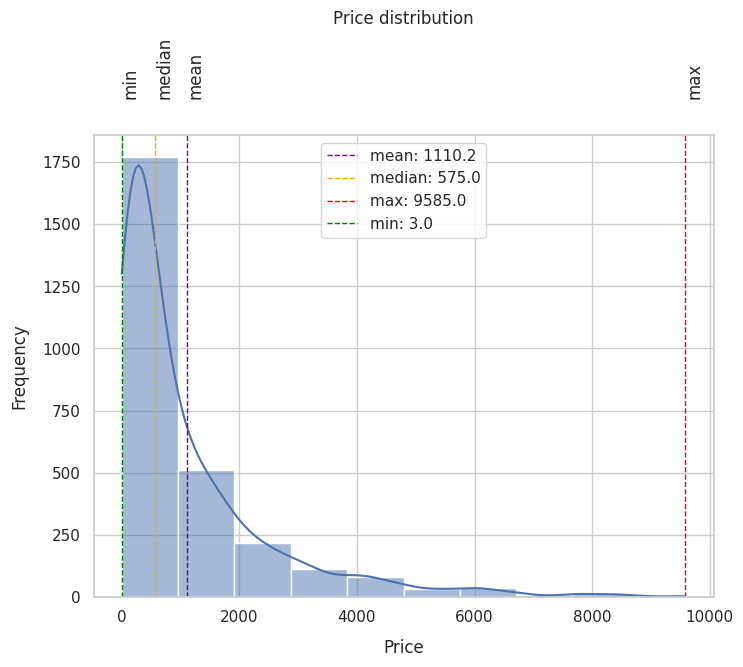

In [163]:
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.histplot(df['price'], bins=10, kde = True);

plt.title('Price distribution', pad = 80)
plt.xlabel('Price', labelpad = 10)
plt.ylabel('Frequency', labelpad = 10)

plt.axvline(df['price'].mean(), color='purple', linestyle='--', linewidth=1, label='mean: {:.1f}'.format(df['price'].mean()))
plt.axvline(df['price'].median(), color='orange', linestyle='--', linewidth=1, label='median: {:.1f}'.format(df['price'].median()))
plt.axvline(df['price'].max(), color='red', linestyle='--', linewidth=1, label='max: {:.1f}'.format(df['price'].max()))
plt.axvline(df['price'].min(), color='green', linestyle='--', linewidth=1, label='min: {:.1f}'.format(df['price'].min()))

plt.text(df['price'].mean(), 2020, 'mean', rotation=90, va='baseline')
plt.text(df['price'].median(), 2020, 'median', rotation=90, va='baseline')
plt.text(df['price'].max(), 2020, 'max', rotation=90, va='baseline')
plt.text(df['price'].min(), 2020, 'min', rotation=90, va='baseline')

plt.legend()
plt.show();

**Розподіл цін по категоріям**

In [164]:
df['category'].value_counts()

category
Bookcases & shelving units              536
Sofas & armchairs                       377
Chairs                                  348
Tables & desks                          344
Wardrobes                               206
Beds                                    198
Outdoor furniture                       195
Cabinets & cupboards                    187
Chests of drawers & drawer units        106
TV & media furniture                     89
Children's furniture                     74
Bar furniture                            39
Nursery furniture                        22
Trolleys                                 20
Café furniture                           17
Sideboards, buffets & console tables     10
Room dividers                            10
Name: count, dtype: int64

**Розподіл даних по категоріям**

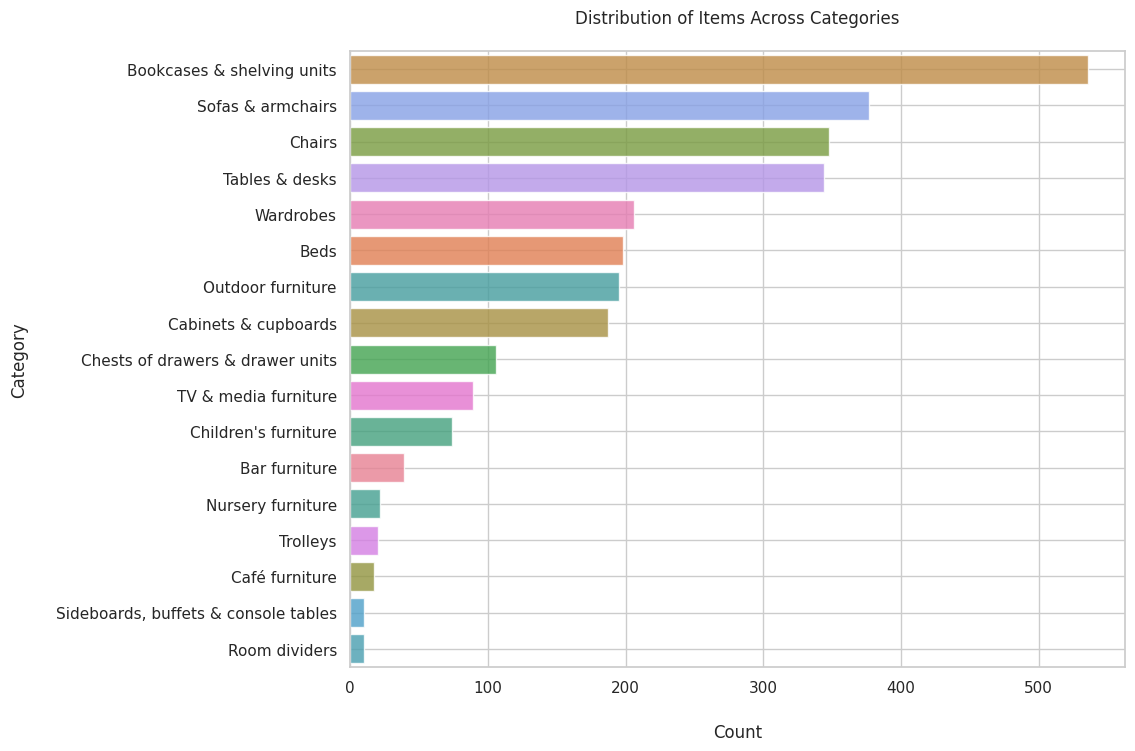

In [165]:
plt.subplots(figsize=(10,8))
sns.countplot(data=df, y='category', hue='category',alpha = 0.8, order=df['category'].value_counts().index);
plt.xlabel('Count', labelpad=20)
plt.ylabel('Category', labelpad=20)
plt.title('Distribution of Items Across Categories', pad=20)
plt.grid(True)
plt.show();

**Розподіл цін по категоріям**

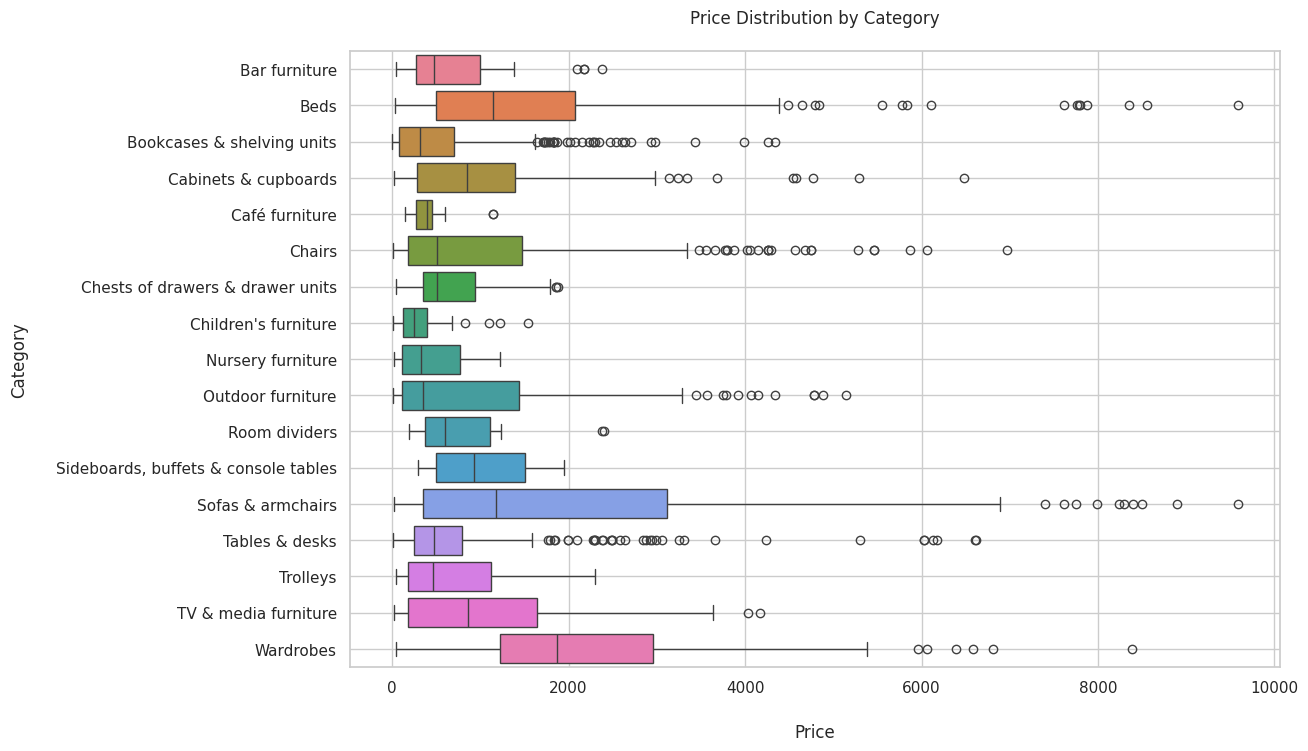

In [166]:
plt.subplots(figsize=(12,8))
sns.boxplot(data=df,x = 'price', y = 'category', hue='category')
plt.ylabel('Category', labelpad = 20)
plt.xlabel('Price', labelpad = 20)
plt.title('Price Distribution by Category',pad = 20)
plt.grid(True)
plt.show()

З графіку видно, що найпоширенішою категорією є 'Bookcases & shelving units', а найменш - 'Room dividers '.

Також бачимо, що розподіл нерівномірний, та моємо значні викиди в цінах майже в усіх категоріях.




**Подивимось статистику в розрізі категорій**

In [167]:
df[df.category == 'Bookcases & shelving units'].describe()

,price,depth,height,width
count,536.00000,444.00000,434.00000,484.00000
mean,527.67164,36.99324,132.13594,107.26653
std,637.07557,13.41834,68.23037,72.50571
min,3.00000,1.00000,3.00000,1.00000
25%,78.00000,30.00000,70.00000,60.00000
50%,315.00000,36.00000,147.00000,81.00000
75%,701.25000,41.00000,190.00000,160.00000
max,4335.00000,159.00000,240.00000,344.00000


In [168]:
df[df.category == 'TV & media furniture'].describe()


,price,depth,height,width
count,89.00000,75.00000,79.00000,86.00000
mean,1045.65169,40.90667,110.49367,164.94186
std,1010.99734,9.16836,72.17906,93.21466
min,17.00000,20.00000,15.00000,9.00000
25%,175.00000,40.00000,49.00000,100.00000
50%,860.00000,41.00000,74.00000,160.00000
75%,1645.00000,42.00000,191.50000,240.00000
max,4175.00000,100.00000,251.00000,336.00000


In [169]:
price_stats = df.groupby('category')['price'].agg(['max', 'mean', 'median', 'min']).reset_index()
price_stats = price_stats.sort_values('max', ascending=False).reset_index(drop=True)
price_stats

,category,max,mean,median,min
0,Sofas & armchairs,9585.00000,1983.02653,1176.00000,27.00000
1,Beds,9585.00000,1689.60606,1142.00000,30.00000
2,Wardrobes,8380.00000,2186.59951,1870.00000,45.00000
3,Chairs,6965.00000,1036.92414,512.00000,11.40000
4,Tables & desks,6614.00000,778.21512,475.00000,9.00000
5,Cabinets & cupboards,6480.00000,1044.82353,845.00000,22.00000
6,Outdoor furniture,5144.00000,924.65949,345.00000,9.00000
7,Bookcases & shelving units,4335.00000,527.67164,315.00000,3.00000
8,TV & media furniture,4175.00000,1045.65169,860.00000,17.00000
9,Room dividers,2397.00000,912.60000,595.00000,189.00000


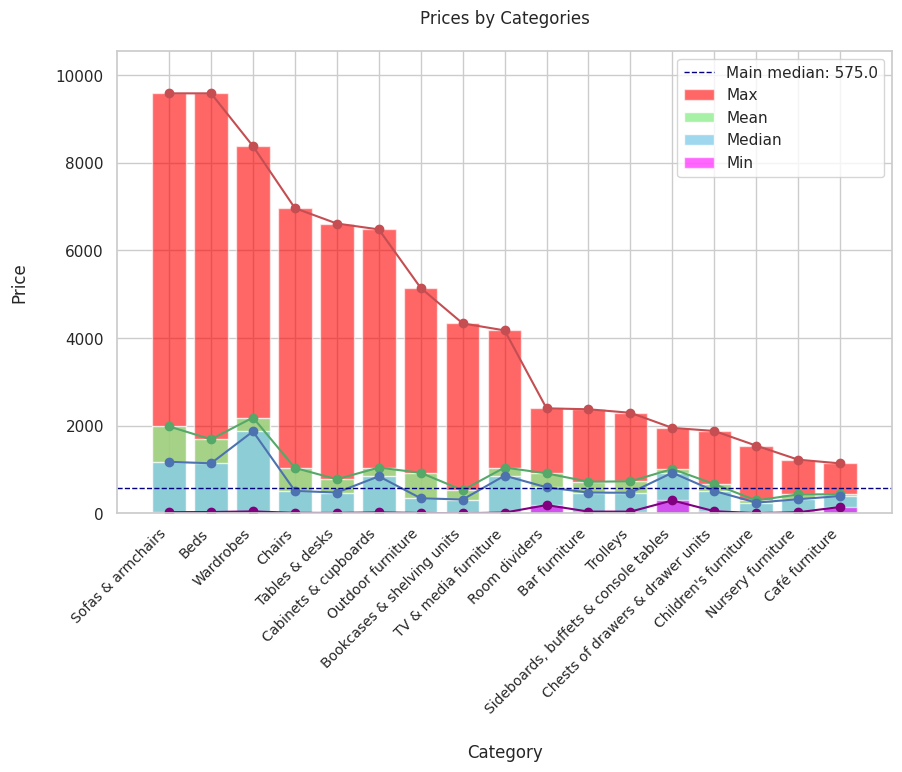

In [170]:
fig, ax = plt.subplots(figsize=(10, 6))

# Побудова стовпчиків для максимальних, середніх, медіанних та мінімальних цін
ax.bar(price_stats['category'], price_stats['max'], label='Max', color='red', alpha=0.6)
ax.bar(price_stats['category'], price_stats['mean'], label='Mean', color='lightgreen', alpha=0.8)
ax.bar(price_stats['category'], price_stats['median'], label='Median', color='skyblue', alpha=0.8)
ax.bar(price_stats['category'], price_stats['min'], label='Min', color='magenta', alpha=0.6)

# Побудова ліній тренду для максимальних, середніх, медіанних та мінімальних цін
ax.plot(price_stats['category'], price_stats['max'], marker='o', linestyle='-', color='r')
ax.plot(price_stats['category'], price_stats['mean'], marker='o', linestyle='-', color='g')
ax.plot(price_stats['category'], price_stats['median'], marker='o', linestyle='-', color='b')
ax.plot(price_stats['category'], price_stats['min'], marker='o', linestyle='-', color='purple')
plt.axhline(df['price'].median(), color='navy', linestyle='--', linewidth=1, label='Main median: {:.1f}'.format(df['price'].median()))

plt.ylim(0, price_stats['max'].max() * 1.1)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Prices by Categories', pad = 20)
plt.xlabel('Category', labelpad = 20)
plt.ylabel('Price', labelpad = 20)
plt.legend()
plt.grid(True)

plt.show();

In [171]:
df['price'].median() # загальна медіанна ціна

575.0

Значення цін(mean, median, min, max) в розрізі категорій дуже різняться.

Відхилення медіанної ціни в категоріях _Sofas & armchairs_, _Beds_, _Wardrobes_ від загальної медіанної ціни(575 саудівських ріал) є суттєвим, а в категоріях _Chairs_, _Tables & desks_, _Room dividers_ та _Chests of drawers & drawer units_ медіанні ціни дуже близькі.

Найбільшу медіанну(а через наявність значних викидів доцільніше спиратися саме на неї, оскільки медіана меньш схильна до впливу викідів) ціну серед усіх категорій мають категорії _Wardrobes_ та  _Sofas & armchairs_.

In [172]:
df[df['price'] == df['price'].min()] # Товар з найменшою вартістю

,name,category,price,sellable_online,other_colors,short_description,depth,height,width,designer_clean
368,GUBBARP,Bookcases & shelving units,3.00000,True,Yes,"Knob, 21 mm",27.00000,NaN,NaN,A Fredriksson/H Preutz


Найдешевший товар з категорії _Bookcases & shelving units_ коштує 3.0 саудівські ріала.

In [173]:
df[df['price'] == df['price'].max()]  # найдорожчий товар

,name,category,price,sellable_online,other_colors,short_description,depth,height,width,designer_clean
179,LIDHULT,Beds,9585.00000,True,Yes,"Corner sofa-bed, 6-seat",164.00000,102.00000,387.00000,Henrik Preutz/IKEA of Sweden
1863,LIDHULT,Sofas & armchairs,9585.00000,True,Yes,"Corner sofa-bed, 6-seat",164.00000,102.00000,387.00000,Henrik Preutz/IKEA of Sweden


Найдорожчий товар  -  2 товари з категорій _Beds_ та _Sofas & armchairs_ мають однакову ціну 9585.0 ріал.

**Подивимось детальніше на розподіл ціни по топ-5 категоріях**

In [174]:
df_top5 = df['category'].value_counts().head(5).reset_index()
top_categories = df_top5['category'].unique()
top_categories

array(['Bookcases & shelving units', 'Sofas & armchairs', 'Chairs',
       'Tables & desks', 'Wardrobes'], dtype=object)

In [175]:
for category in top_categories:
  print(f'{category}')
  print(df[df.category == category].describe())

Bookcases & shelving units
           price     depth    height     width
count  536.00000 444.00000 434.00000 484.00000
mean   527.67164  36.99324 132.13594 107.26653
std    637.07557  13.41834  68.23037  72.50571
min      3.00000   1.00000   3.00000   1.00000
25%     78.00000  30.00000  70.00000  60.00000
50%    315.00000  36.00000 147.00000  81.00000
75%    701.25000  41.00000 190.00000 160.00000
max   4335.00000 159.00000 240.00000 344.00000
Sofas & armchairs
           price     depth    height     width
count  377.00000 195.00000 239.00000 230.00000
mean  1983.02653 108.13846  77.83682 188.32174
std   2080.27803  42.49350  24.90610  94.16417
min     27.00000   6.00000   4.00000  15.00000
25%    350.00000  89.00000  70.50000  93.00000
50%   1176.00000  98.00000  83.00000 198.50000
75%   3120.00000 113.00000  95.50000 252.00000
max   9585.00000 257.00000 104.00000 387.00000
Chairs
           price     depth    height     width
count  348.00000 204.00000 215.00000 288.00000
mean  10

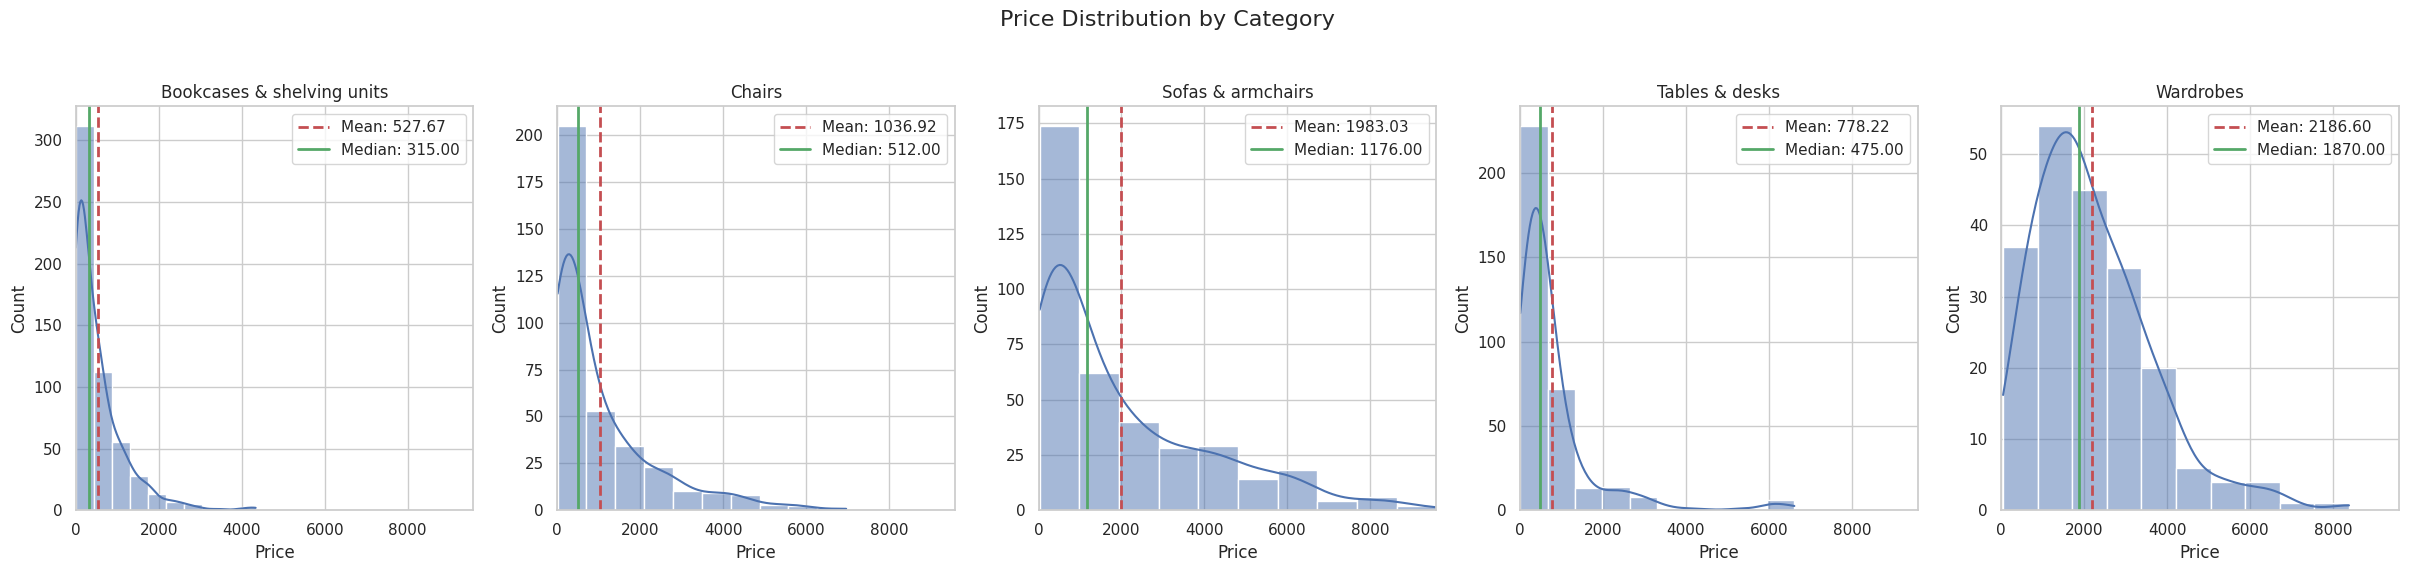

In [176]:
fig, ax = plt.subplots(1,5,figsize=(25, 6))
max_price = df['price'].max()

#Bookcases & shelving units
df_book = df[df['category'] == 'Bookcases & shelving units']
mean_price = df_book['price'].mean()
median_price = df_book['price'].median()

ax1 = sns.histplot(df_book['price'], kde = True, bins= 10,ax = ax[0]);
ax[0].axvline(mean_price, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_price:.2f}');
ax[0].axvline(median_price, color='g', linestyle='-', linewidth=2, label=f'Median: {median_price:.2f}');
ax[0].set(xlabel='Price',xlim = (0, max_price), title ='Bookcases & shelving units')
ax[0].legend()

#Chairs
df_chair = df[df['category'] == 'Chairs']
mean_price = df_chair['price'].mean()
median_price = df_chair['price'].median()
ax2 = sns.histplot(df_chair.price, kde = True, bins= 10, ax = ax[1]);

ax[1].axvline(mean_price, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_price:.2f}')
ax[1].axvline(median_price, color='g', linestyle='-', linewidth=2, label=f'Median: {median_price:.2f}')
ax[1].set(xlabel='Price',xlim = (0, max_price), title ='Chairs')
ax[1].legend()

#Sofas & armchairs
df_sofa = df[df['category'] == 'Sofas & armchairs']
mean_price = df_sofa['price'].mean()
median_price = df_sofa['price'].median()
ax3 = sns.histplot(df_sofa.price, kde = True, bins= 10, ax = ax[2]);

ax[2].axvline(mean_price, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_price:.2f}')
ax[2].axvline(median_price, color='g', linestyle='-', linewidth=2, label=f'Median: {median_price:.2f}')
ax[2].set(xlabel='Price',xlim = (0, max_price), title ='Sofas & armchairs')
ax[2].legend()

#Tables & desks
df_table = df[df['category'] == 'Tables & desks']
mean_price = df_table['price'].mean()
median_price = df_table['price'].median()
ax4 = sns.histplot(df_table.price, kde = True, bins= 10, ax = ax[3]);

ax[3].axvline(mean_price, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_price:.2f}')
ax[3].axvline(median_price, color='g', linestyle='-', linewidth=2, label=f'Median: {median_price:.2f}')
ax[3].set(xlabel='Price',xlim = (0, max_price), title ='Tables & desks')
ax[3].legend()

#Wardrobes
df_wardrobe = df[df['category'] == 'Wardrobes']
mean_price = df_wardrobe['price'].mean()
median_price = df_wardrobe['price'].median()
ax5 = sns.histplot(df_wardrobe.price, kde = True, bins= 10, ax=ax[4]);

ax[4].axvline(mean_price, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_price:.2f}')
ax[4].axvline(median_price, color='g', linestyle='-', linewidth=2, label=f'Median: {median_price:.2f}')
ax[4].set(xlabel='Price',xlim = (0, max_price), title ='Wardrobes')
ax[4].legend()

fig.suptitle('Price Distribution by Category', fontsize=16)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])

plt.grid(True)
plt.show();

Дані в найпопулярніших категоріях нерівномірні, мають значний розмах в ціні, а велика різниця між значення середньої та медіанної ціни вказує на викиди.

Також бачимо суттєве відхилення медіанної ціни в кожній категорії від загальної медіанної ціни.
Найменшу мінімальну ціну товара маємо у категорії _Bookcases & shelving units_, а найбільшу мінімальну ціну у категорії _Wardrobes_.

Щодо максимальної вартості товара, то найменша максимальна вартість також в категорії _Bookcases & shelving units_, а максимальна у категоріі _Sofas & armchairs_.


### **Подивимося на колонку _sellable_online_**

In [177]:
online = df['sellable_online'].value_counts()
online

sellable_online
True     2760
False      18
Name: count, dtype: int64

In [178]:
df['sellable_online'].value_counts(normalize = True)

sellable_online
True    0.99352
False   0.00648
Name: proportion, dtype: float64

Подивимось які саме товари не продаються онлайн.

In [179]:
df[df['sellable_online']==False]

,name,category,price,sellable_online,other_colors,short_description,depth,height,width,designer_clean
1,NORDVIKEN,Bar furniture,995.00000,False,No,"Bar table, 140x80 cm",NaN,105.00000,80.00000,Francis Cayouette
2,NORDVIKEN / NORDVIKEN,Bar furniture,2095.00000,False,No,Bar table and 4 bar stools,NaN,NaN,NaN,Francis Cayouette
30,NORDVIKEN,Bar furniture,275.00000,False,No,"Bar stool with backrest, 75 cm",47.00000,101.00000,40.00000,Francis Cayouette
44,SLÄKT,Beds,540.00000,False,No,"Ext bed frame with slatted bed base, ...",NaN,NaN,91.00000,Ebba Strandmark/IKEA of Sweden
149,SLÄKT,Beds,520.00000,False,No,"Ext bed frame with slatted bed base, ...",NaN,NaN,91.00000,Ebba Strandmark/IKEA of Sweden
211,SLÄKT,Beds,75.00000,False,Yes,Headboard,NaN,40.00000,90.00000,Ebba Strandmark
593,HACKÅS,Bookcases & shelving units,50.00000,False,No,"Handle, 300 mm",18.00000,NaN,24.00000,J Löfgren/J Pettersson
1273,VOLFGANG,Chairs,175.00000,False,No,Stool,43.00000,85.00000,53.00000,IKEA of Sweden
1298,EKEDALEN / EKEDALEN,Chairs,1245.00000,False,No,"Table and 2 chairs, 80/120 cm",NaN,NaN,NaN,Ehlén Johansson
1315,EKEDALEN / ODGER,Chairs,1149.00000,False,No,"Table and 2 chairs, 80/120 cm",NaN,NaN,NaN,Ehlén Johansson/J Löfgren/J Pettersson


In [180]:
df['category'][df['sellable_online']==False].value_counts()

category
Children's furniture          4
Bar furniture                 3
Beds                          3
Chairs                        3
Bookcases & shelving units    1
Nursery furniture             1
Sofas & armchairs             1
Tables & desks                1
Trolleys                      1
Name: count, dtype: int64

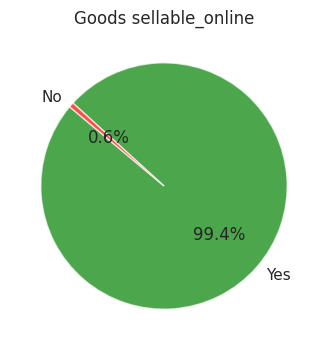

In [181]:
plt.figure(figsize=(4, 4))
sns.set_style('whitegrid')

plt.pie(online, labels=['Yes', 'No'], autopct='%1.1f%%', startangle=140,colors = ['green', 'red'], wedgeprops={'alpha': 0.7,});

plt.title('Goods sellable_online')
plt.show();

**Розподіл цін товарів за наявністю онлайн-продажів**

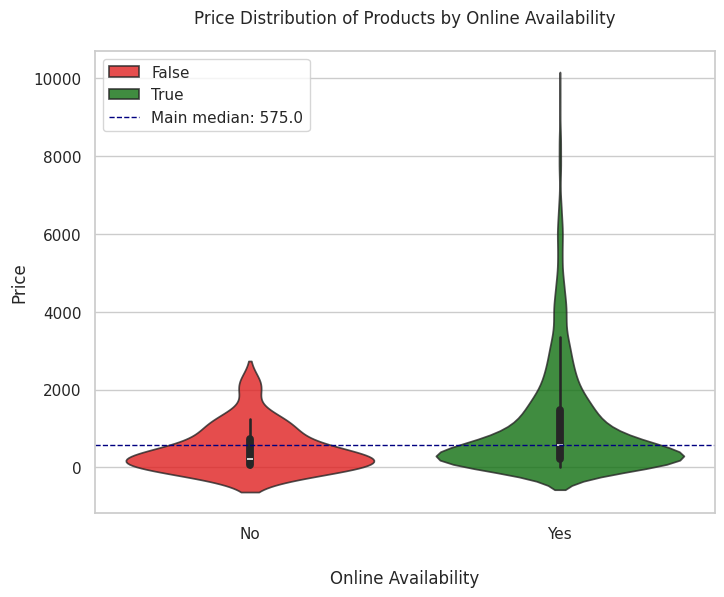

In [182]:
plt.figure(figsize=(8, 6))

ax = sns.violinplot(x='sellable_online', y='price', data=df,hue = 'sellable_online', palette=['red', 'green'], alpha = 0.8);
ax.axhline(df['price'].median(), color='navy', linestyle='--', linewidth=1, label='Main median: {:.1f}'.format(df['price'].median()))

plt.xlabel('Online Availability', labelpad = 20)
plt.ylabel('Price')
plt.title('Price Distribution of Products by Online Availability', pad = 20)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.legend(loc = 'upper left')
plt.show();

Частка товарів, які не представлені онлайн складає 0.6479%. Закономірності між товарами, які не продаються онлайн не виявлено. Наявні товари як з найпоширеніших категорій, так і з менш популярних.Ціни цих товарів теж різноманітні, бачимо як крупногабаритні товари, так і невеликі аксесуари.

Що стосується ціни, то товари які не доступні онлайн мають нижчу медіанну ціну, тож цілком можна припустити, що це залишки залежалого товару(або товару, який виводиться з асортименту), в обмеженій кількості які продаються зі знижкою лише в тих магазинах, де є в наявності, або пошкоджені та уцінені товари, чи товари з виставкової зали.

### **Подивимося на колонку _other_colors_**

In [183]:
df['other_colors'].value_counts()  #кількісне співвідношення наявності іншого кольору

other_colors
No     1469
Yes    1309
Name: count, dtype: int64

In [184]:
df['other_colors'].value_counts(normalize = True) # процентне співвідношення наявності іншого кольору

other_colors
No    0.52880
Yes   0.47120
Name: proportion, dtype: float64

Поглянемо на наявність кольорів в розрізі категорій

In [185]:
colors = df.groupby(['category', 'other_colors']).size().unstack(fill_value=0).reset_index()
colors.columns = ['category', 'No', 'Yes']
colors

,category,No,Yes
0,Bar furniture,34,5
1,Beds,105,93
2,Bookcases & shelving units,307,229
3,Cabinets & cupboards,47,140
4,Café furniture,12,5
5,Chairs,257,91
6,Chests of drawers & drawer units,51,55
7,Children's furniture,46,28
8,Nursery furniture,15,7
9,Outdoor furniture,119,76


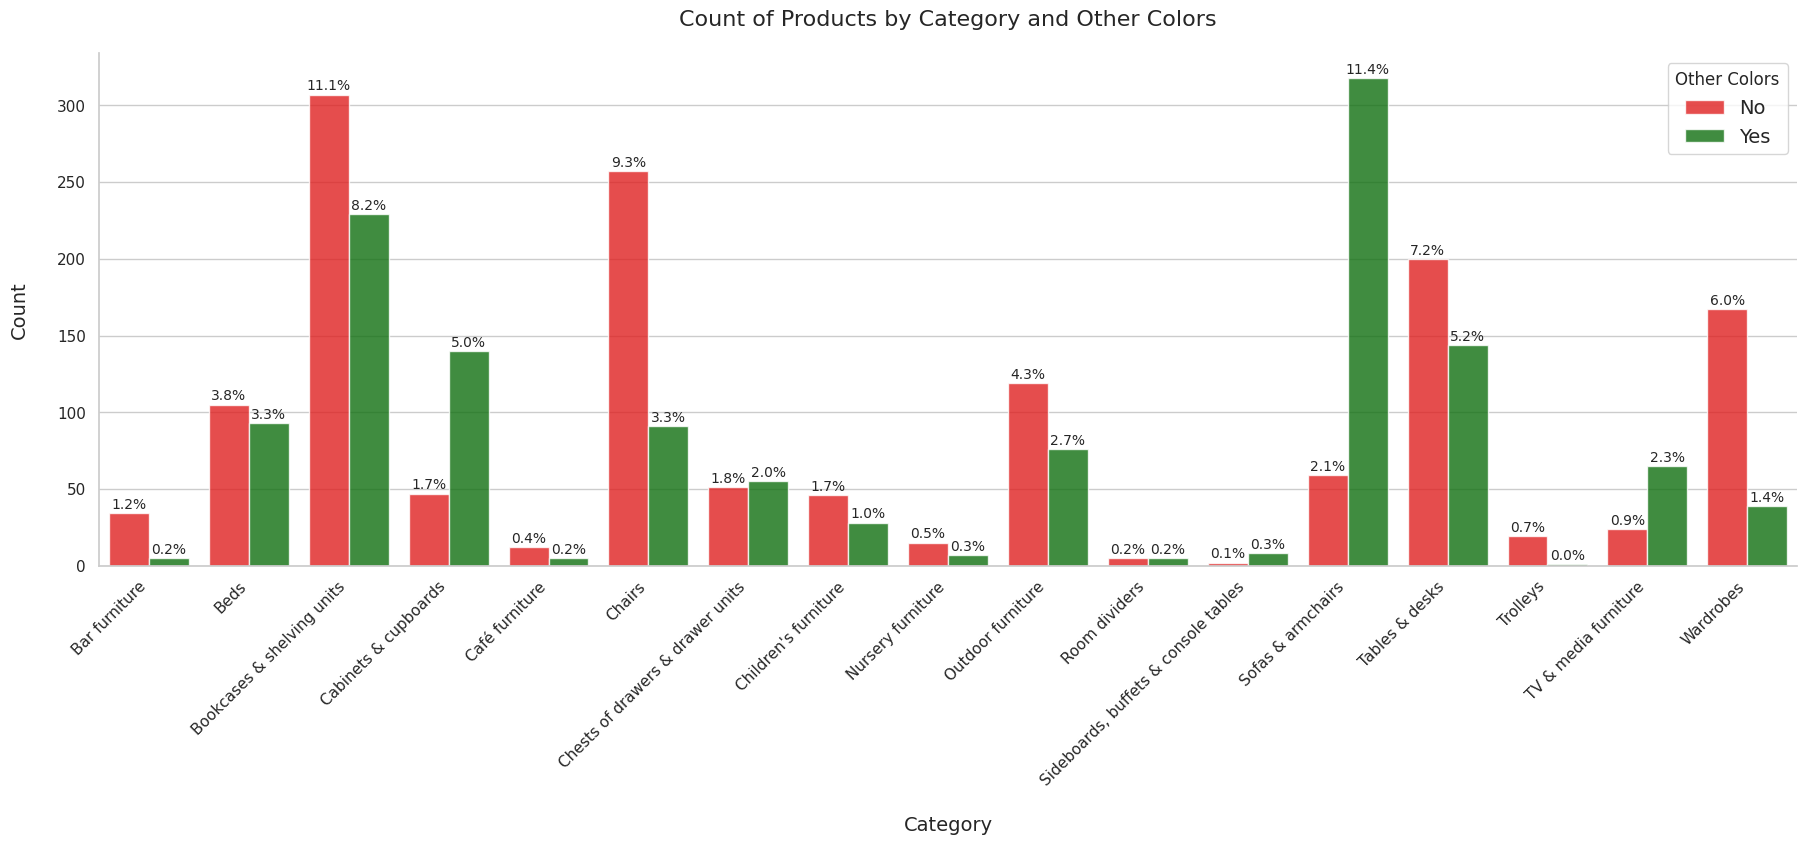

In [186]:
g = sns.catplot(x='category', hue='other_colors', data=df, kind='count', palette=['red', 'green'],alpha = 0.8, height=6, aspect=3, legend = (False));

plt.xticks(rotation=45, ha='right')
plt.title('Count of Products by Category and Other Colors',fontsize = 16,pad = 20)
plt.xlabel('Category', labelpad = 20,fontsize = 14)
plt.ylabel('Count', labelpad = 20,fontsize = 14)
plt.legend(title='Other Colors', labels=['No', 'Yes'],fontsize = 14)

total = len(df)
for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        percentage = '{:.1f}%'.format(100 * height / total)
        ax.text(p.get_x() + p.get_width() / 2., height + 3,percentage, ha='center', rotation=0, fontsize = 10)

plt.show();

Частка товарів доступних в різних кольорах складає 47.12%, але в розрізі категорій співвідношення різниться.
Так бачимо що навіть в найпоширеніших категоріях _Bookcases & shelving units_, _Chairs_, _Tables & desks_ та _Wardrobes_ частка товарів не предсталених в інших кольорах більша, а от в категоріях _Sofas & armchairs_ та _Cabinets & cupboards_  більшість товарів доступні в різних кольорах.

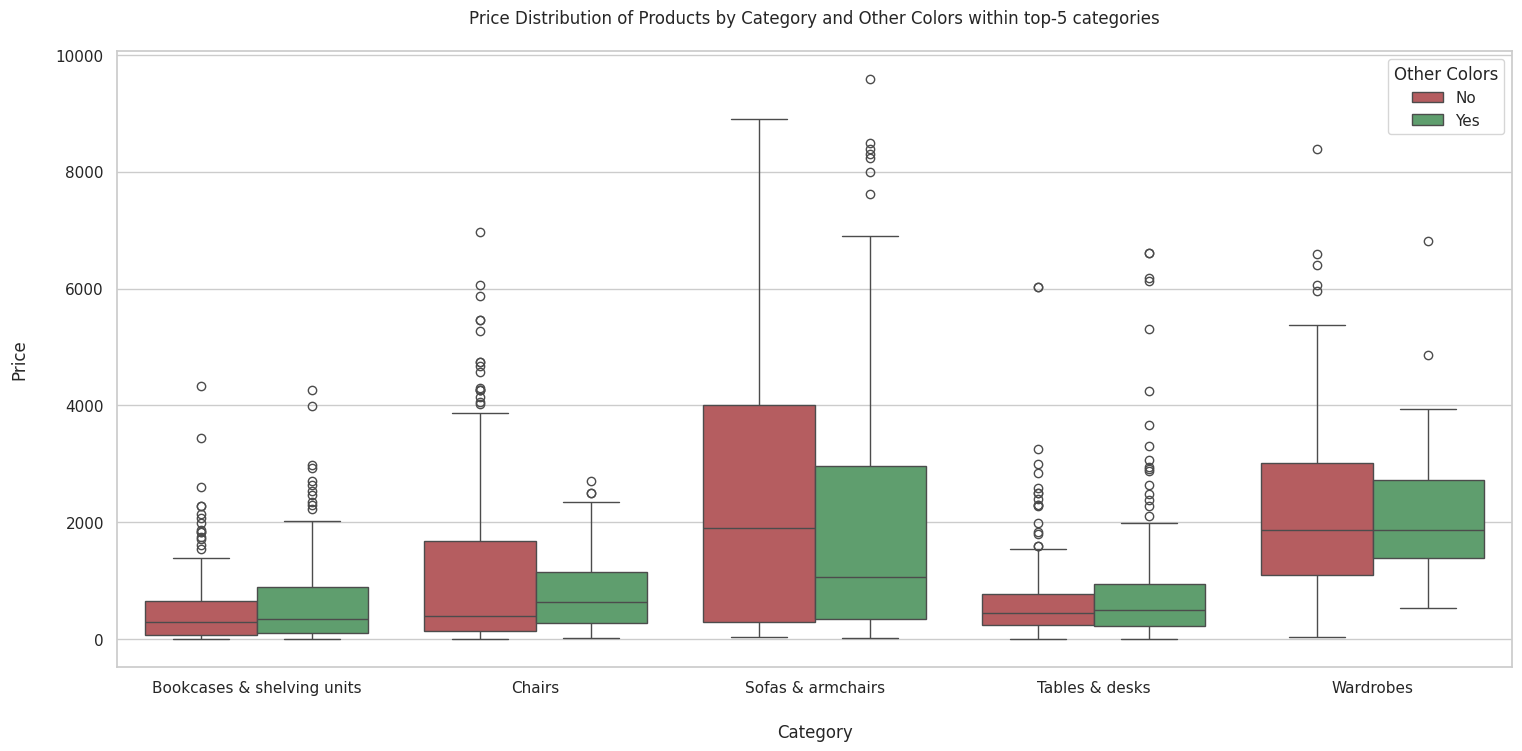

In [290]:
top5 = df[df['category'].isin(top_categories)].reset_index()
plt.figure(figsize=(18, 8))
sns.boxplot(top5,x = 'category', y = 'price', hue = 'other_colors',palette =['r', 'g']);

plt.title('Price Distribution of Products by Category and Other Colors within top-5 categories', pad = 20)
plt.ylabel('Price', labelpad = 20)
plt.xlabel('Category', labelpad = 20)
plt.legend(title='Other Colors')
plt.show();

Щодо розподілу цін серед товарів топ-5 категорій в залежності від представлення товарів в різних кольорах, то лише в категорії _Sofas & armchairs_ маємо значну різницю в медіанній ціні, причому у товарів представлених в одному кольорі вона вище.В категорії _Chairs_ навпаки медіанна ціна товарів , доступних в різних кольорах трохи вища, в інших категоріях коливання незначні, або ціни співпадають.  



### **Розглянемо колонку _designer_clean_**

In [188]:
df['designer_clean'].describe()

count               2778
unique               199
top       IKEA of Sweden
freq                 746
Name: designer_clean, dtype: object

In [189]:
df_top_desiner = df.groupby('designer_clean')['designer_clean'].value_counts().sort_values(ascending=False).reset_index().head()
df_top_desiner

,designer_clean,count
0,IKEA of Sweden,746
1,Francis Cayouette,126
2,Ehlén Johansson/IKEA of Sweden,123
3,Ehlén Johansson,123
4,Ola Wihlborg,120


Як бачимо IKEA має штат власних дизайнерів(IKEA of Sweden), які охоплюють більшу частку ассортименту, а також співпрацюють зі сторонніми дизайнерами.

In [190]:
top_desiner =df_top_desiner['designer_clean'].unique()
top_desiner

array(['IKEA of Sweden', 'Francis Cayouette',
       'Ehlén Johansson/IKEA of Sweden', 'Ehlén Johansson',
       'Ola Wihlborg'], dtype=object)

In [191]:
df_top_desiner = df[df['designer_clean'].isin(top_desiner)]
df_top_desiner

,name,category,price,sellable_online,other_colors,short_description,depth,height,width,designer_clean
1,NORDVIKEN,Bar furniture,995.00000,False,No,"Bar table, 140x80 cm",NaN,105.00000,80.00000,Francis Cayouette
2,NORDVIKEN / NORDVIKEN,Bar furniture,2095.00000,False,No,Bar table and 4 bar stools,NaN,NaN,NaN,Francis Cayouette
8,EKEDALEN / EKEDALEN,Bar furniture,2176.00000,True,No,Bar table and 4 bar stools,NaN,NaN,NaN,Ehlén Johansson
13,EKEDALEN,Bar furniture,345.00000,True,No,"Bar stool with backrest, 75 cm",52.00000,114.00000,43.00000,Ehlén Johansson
18,EKEDALEN,Bar furniture,995.00000,True,No,"Bar table, 120x80 cm",NaN,105.00000,80.00000,Ehlén Johansson
...,...,...,...,...,...,...,...,...,...,...
2773,PAX / MEHAMN/AULI,Wardrobes,2045.00000,True,No,"Wardrobe combination, 200x66x...",66.00000,236.00000,200.00000,Ehlén Johansson/IKEA of Sweden
2774,ELVARLI,Wardrobes,750.00000,True,No,"1 section, 92x51x222-350 cm",50.00000,NaN,91.00000,Ehlén Johansson
2775,ELVARLI,Wardrobes,1572.00000,True,No,"2 sections, 135x51x222-350 cm",50.00000,NaN,135.00000,Ehlén Johansson
2776,ELVARLI,Wardrobes,924.00000,True,No,"2 sections, 175x51x222-350 cm",50.00000,NaN,175.00000,Ehlén Johansson


In [192]:
df_top_desiner['category'].unique()

array(['Bar furniture', 'Beds', 'Bookcases & shelving units',
       'Cabinets & cupboards', 'Café furniture', 'Chairs',
       'Chests of drawers & drawer units', "Children's furniture",
       'Nursery furniture', 'Outdoor furniture', 'Room dividers',
       'Sideboards, buffets & console tables', 'Sofas & armchairs',
       'Tables & desks', 'Trolleys', 'TV & media furniture', 'Wardrobes'],
      dtype=object)

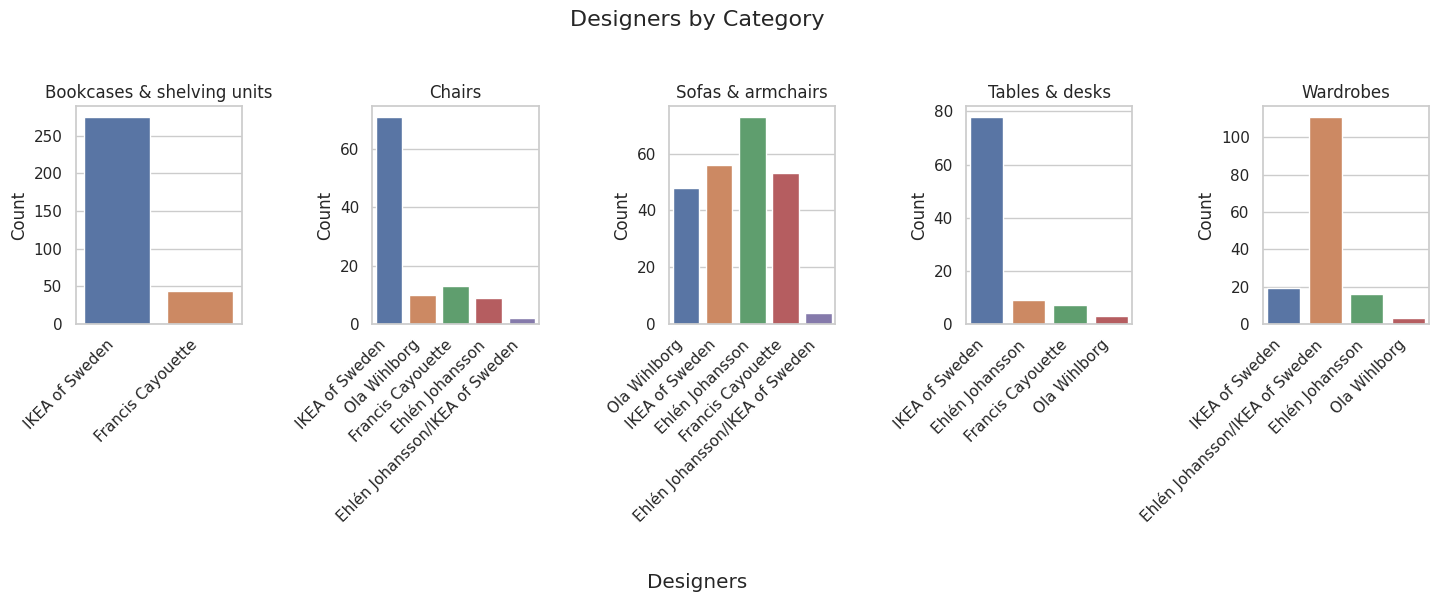

In [193]:
fig, ax = plt.subplots(1,5,figsize=(15, 6))

#Bookcases & shelving units
df_book = df_top_desiner[df_top_desiner['category'] == 'Bookcases & shelving units']
ax1 = sns.countplot(x = df_book['designer_clean'],data =df_book, hue = 'designer_clean',ax =ax[0]);
ax[0].set(ylabel = 'Count',xlabel = None, title ='Bookcases & shelving units')
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=45, ha='right')

#Chairs
df_chair = df_top_desiner[df_top_desiner['category'] == 'Chairs']
ax2 = sns.countplot(x = df_chair['designer_clean'],data =df_chair, hue = 'designer_clean',ax =ax[1]);
ax[1].set(ylabel = 'Count',xlabel = None, title ='Chairs')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45, ha='right')

#Sofas & armchairs
df_sofa = df_top_desiner[df_top_desiner['category'] == 'Sofas & armchairs']
ax3 = sns.countplot(x = df_sofa['designer_clean'], data =df_sofa, hue = 'designer_clean',ax =ax[2]);
ax[2].set(ylabel = 'Count',xlabel = None, title ='Sofas & armchairs')
ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=45, ha='right')

#Tables & desks
df_table = df_top_desiner[df_top_desiner['category'] == 'Tables & desks']
ax4 = sns.countplot(x = df_table['designer_clean'],data =df_table, hue = 'designer_clean',ax =ax[3]);
ax[3].set(ylabel = 'Count',xlabel = None, title ='Tables & desks')
ax[3].set_xticklabels(ax[3].get_xticklabels(),rotation=45, ha='right')

#Wardrobes
df_wardrobe = df_top_desiner[df_top_desiner['category'] == 'Wardrobes']
ax5 = sns.countplot(x = df_wardrobe['designer_clean'],data =df_wardrobe, hue = 'designer_clean',ax =ax[4]);
ax[4].set(ylabel = 'Count',xlabel = None, title ='Wardrobes')
ax[4].set_xticklabels(ax[4].get_xticklabels(),rotation=45, ha='right')

fig.suptitle('Designers by Category', fontsize=16)
fig.supxlabel('Designers')
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])

plt.show();

**Розглянемо розподіл цін всередині категорій в залежності від дизайнера**

In [194]:
top_desiner

array(['IKEA of Sweden', 'Francis Cayouette',
       'Ehlén Johansson/IKEA of Sweden', 'Ehlén Johansson',
       'Ola Wihlborg'], dtype=object)

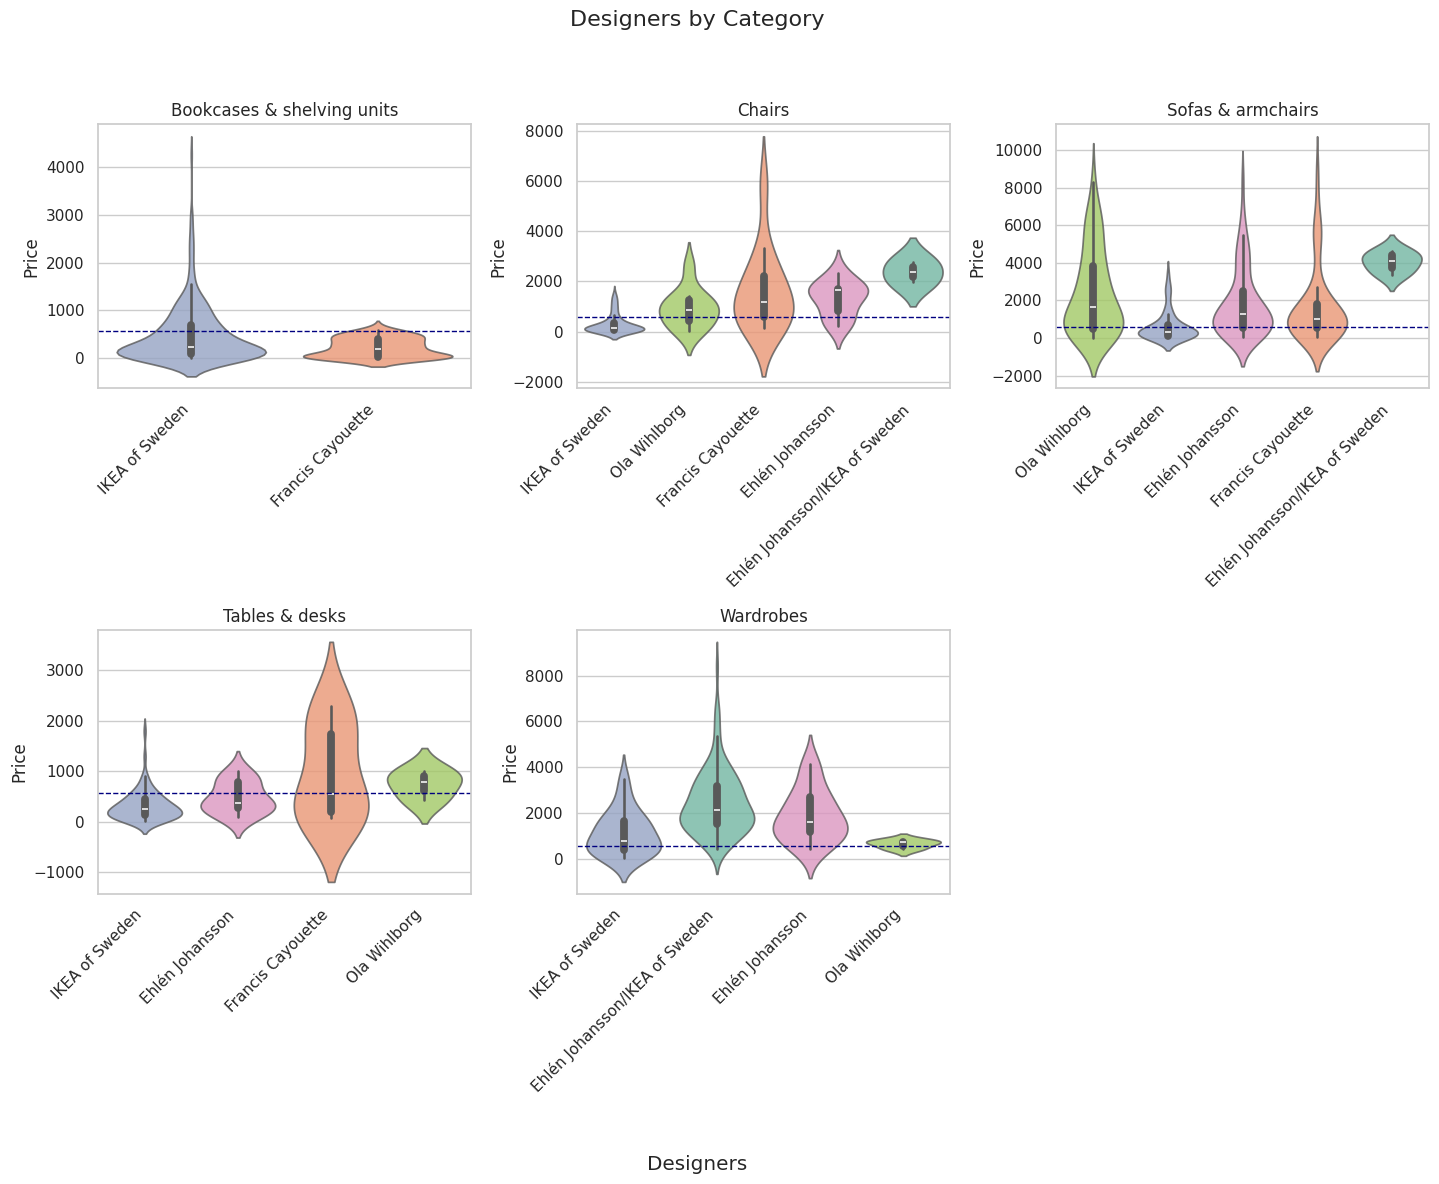

In [195]:
palette_design = {'IKEA of Sweden': '#8da0cb', 'Francis Cayouette': '#fc8d62', 'Ehlén Johansson/IKEA of Sweden': '#66c2a5', 'Ehlén Johansson': '#e78ac3','Ola Wihlborg': '#a6d854'}
fig, ax = plt.subplots(2,3,figsize=(15, 12))

#Bookcases & shelving units
df_book = df_top_desiner[df_top_desiner['category'] == 'Bookcases & shelving units']
ax1 = sns.violinplot(df_book,x = 'designer_clean', palette = palette_design, hue = 'designer_clean', y = 'price' ,alpha = 0.8, ax = ax[0][0]);
ax[0][0].set(ylabel = 'Price',xlabel = None, title ='Bookcases & shelving units')
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(),rotation=45, ha='right')
ax[0][0].axhline(df['price'].median(), color='navy', linestyle='--', linewidth=1, label='Main median: {:.1f}'.format(df['price'].median()))

#Chairs
df_chair = df_top_desiner[df_top_desiner['category'] == 'Chairs']
ax2 = sns.violinplot(df_chair, x = 'designer_clean', palette = palette_design, hue = 'designer_clean', y = 'price' ,alpha = 0.8, ax = ax[0][1]);
ax[0][1].set(ylabel = 'Price',xlabel = None, title ='Chairs')
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(),rotation=45, ha='right')
ax[0][1].axhline(df['price'].median(), color='navy', linestyle='--', linewidth=1, label='Main median: {:.1f}'.format(df['price'].median()))

#Sofas & armchairs
df_sofa = df_top_desiner[df_top_desiner['category'] == 'Sofas & armchairs']
ax3 = sns.violinplot(df_sofa, x = 'designer_clean',palette = palette_design, hue = 'designer_clean', y = 'price' ,alpha = 0.8, ax = ax[0][2]);
ax[0][2].set(ylabel = 'Price',xlabel = None, title ='Sofas & armchairs')
ax[0][2].set_xticklabels(ax[0][2].get_xticklabels(),rotation=45, ha='right')
ax[0][2].axhline(df['price'].median(), color='navy', linestyle='--', linewidth=1, label='Main median: {:.1f}'.format(df['price'].median()))

#Tables & desks
df_table = df_top_desiner[df_top_desiner['category'] == 'Tables & desks']
ax4 = sns.violinplot(df_table, x = 'designer_clean', palette = palette_design,hue = 'designer_clean', y = 'price' ,alpha = 0.8, ax = ax[1][0]);
ax[1][0].set(ylabel = 'Price',xlabel = None, title ='Tables & desks')
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(),rotation=45, ha='right')
ax[1][0].axhline(df['price'].median(), color='navy', linestyle='--', linewidth=1, label='Main median: {:.1f}'.format(df['price'].median()))

#Wardrobes
df_wardrobe = df_top_desiner[df_top_desiner['category'] == 'Wardrobes']
ax5 = sns.violinplot(df_wardrobe, x = 'designer_clean', palette = palette_design, hue = 'designer_clean', y = 'price' ,alpha = 0.8, ax = ax[1][1]);
ax[1][1].set(ylabel = 'Price',xlabel = None, title ='Wardrobes')
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(),rotation=45, ha='right')
ax[1][1].axhline(df['price'].median(), color='navy', linestyle='--', linewidth=1, label='Main median: {:.1f}'.format(df['price'].median()))

ax[1, 2].axis('off')

fig.suptitle('Designers by Category', fontsize=16)
fig.supxlabel('Designers')
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])

plt.show();

In [196]:
df_filtered = df_top_desiner[df_top_desiner['category'].isin(top_categories)]
result = df_filtered.groupby('category')[['designer_clean', 'price']].max().reset_index()
result

,category,designer_clean,price
0,Bookcases & shelving units,IKEA of Sweden,4260.00000
1,Chairs,Ola Wihlborg,5865.00000
2,Sofas & armchairs,Ola Wihlborg,8900.00000
3,Tables & desks,Ola Wihlborg,2295.00000
4,Wardrobes,Ola Wihlborg,8380.00000


In [197]:
df['designer_clean'][df['price'] == df['price'].max()]

179     Henrik Preutz/IKEA of Sweden
1863    Henrik Preutz/IKEA of Sweden
Name: designer_clean, dtype: object

In [198]:
df['designer_clean'][df['price'] == df['price'].min()]

368    A Fredriksson/H Preutz
Name: designer_clean, dtype: object

Розглянувши топ-5 категорій та топ-5 дизайнерів бачимо:
 - медіанна ціна на товари власних дизайнерів IKEA (_IKEA of Sweden_) нижча серед усіх дизайнерів для всіх категорій;

 - медіанна ціна на товари дизайнерів _IKEA of Sweden_ нижча за загальну медіанну ціну для всіх категорій, окрім _Wardrobes_;

 - найвищу медіанну ціну мають товари дизайнера _Ola Wihlborg_.

Дизайнер найдорожчого товару з усіх (без урахування топ категорій та топ дизайнерів) - _Henrik Preutz/IKEA of Sweden_, а найдешевшого - _A Fredriksson/H Preutz_

**Подивимось на взаємозв'язок ціни та габаритних розмірів.**

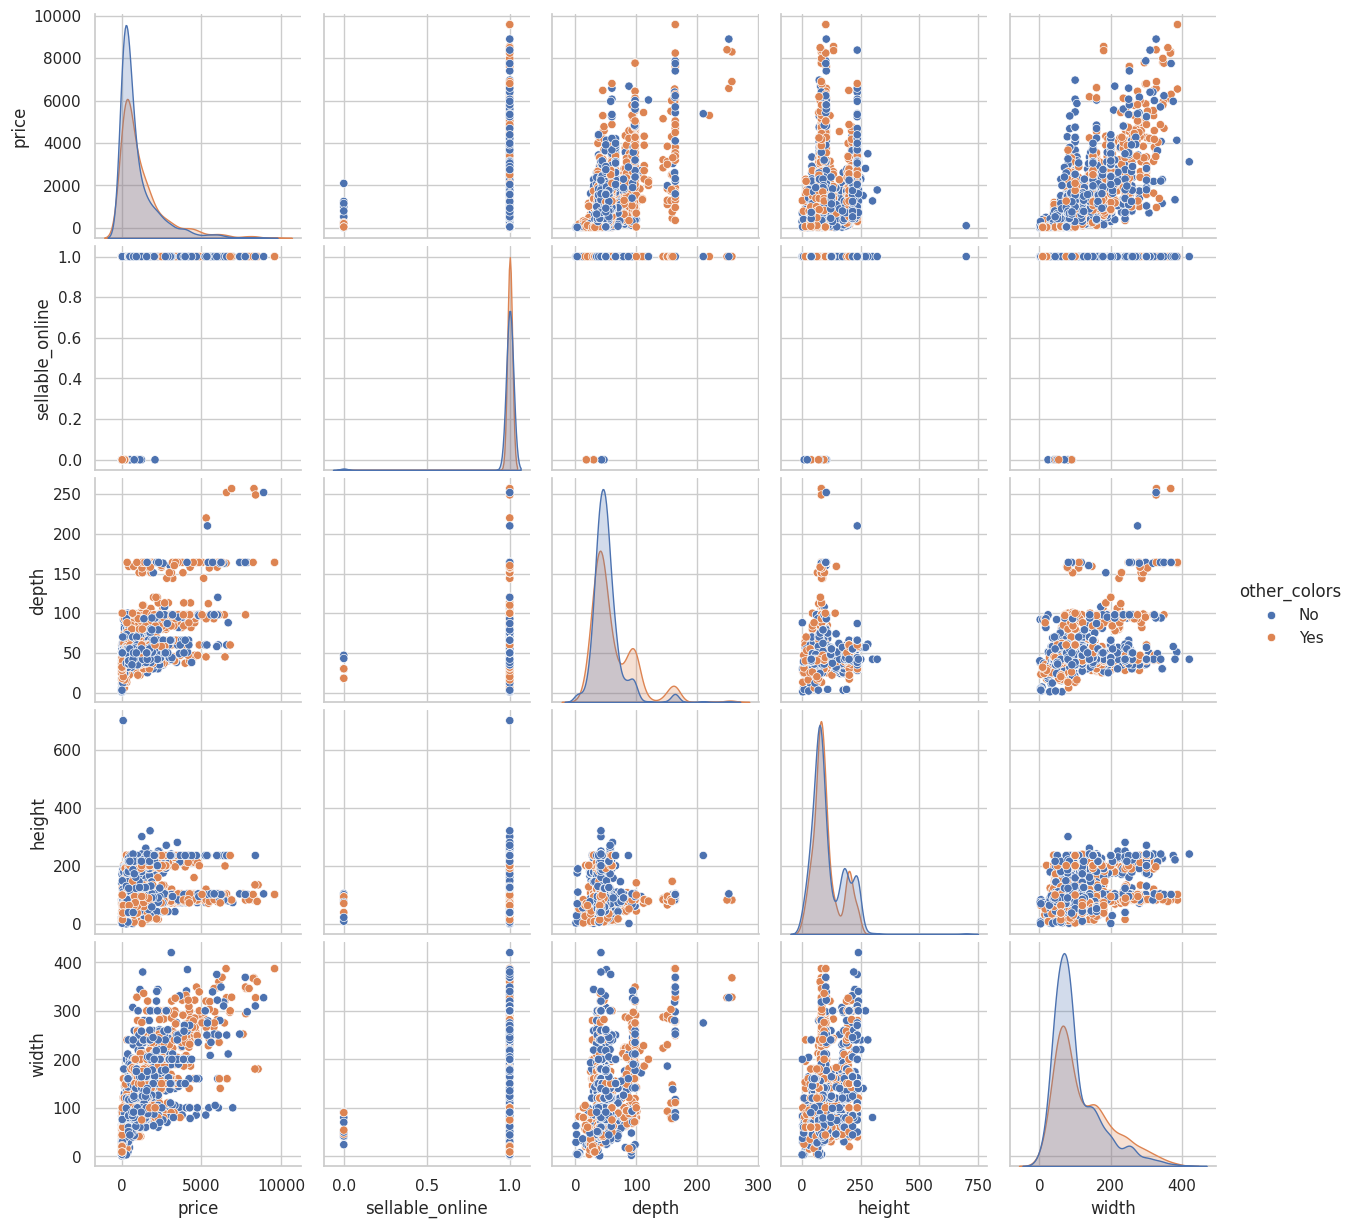

In [199]:
sns.pairplot(df,hue = 'other_colors')

**Поглянемо на теплову карту**

In [200]:
df_heat = df[['height', 'width', 'depth', 'price']]  # підготуємо дані

Спочатку застосуємо кореляцію Пірсона, щоб оцінити лінійну залежність між показниками.

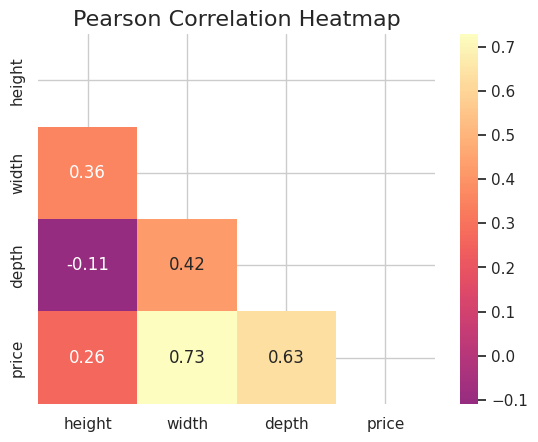

In [201]:
corr = df_heat.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", center=0, cmap='magma', xticklabels=corr.columns, yticklabels=corr.columns);
plt.title('Pearson Correlation Heatmap', fontsize=16)
plt.show();

Далі кореляцію Спірмана, оскільки вона більш стійка до нелінійних зв'язків і аномалій у даних.


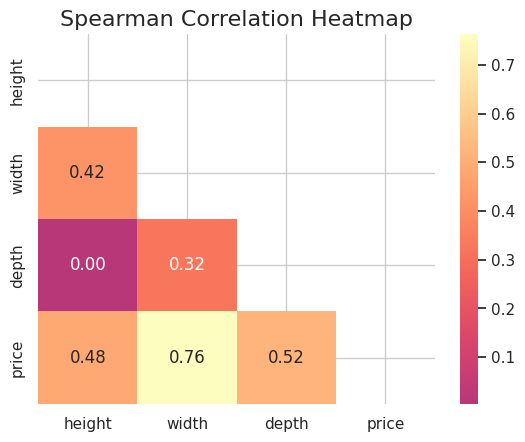

In [202]:
corr_spearman = df_heat.corr(method='spearman')
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))
sns.heatmap(corr_spearman, mask=mask, annot=True, fmt=".2f", center=0, cmap='magma', xticklabels=corr_spearman.columns, yticklabels=corr_spearman.columns);
plt.title('Spearman Correlation Heatmap', fontsize=16)
plt.show()

Бачимо , що існує суттєва залежність між ціною і шириною, та дещо менша залежність між ціною та висотою.

## **3.Перевірка гіпотез.**
 На основі EDA та вашого здорового глузду виберіть дві гіпотези, які ви хочете перевірити/проаналізувати. Для кожної гіпотези перерахуйте нульову гіпотезу та інші можливі альтернативні гіпотези, розробіть тести для їх розрізнення та виконайте їх. Опишіть результати.

### **3.1.Формулювання гіпотези 1:**

 - **Нульова гіпотеза ($H_0$)**: Медіанна ціна товарів, які не представлені онлайн, дорівнює медіанній ціні товарів, які є в онлайн-продажу.

 - **Альтернативна гіпотеза ($H_1$)**: Медіанна ціна товарів, які не представлені онлайн, є нижчою за медіанну ціну товарів, які є в онлайн-продажу.

Підготуємо дані для аналізу.

Розділимо дані на групи.

In [240]:
online_prices = df[df['sellable_online'] == True]['price']
offline_prices = df[df['sellable_online'] == False]['price']

In [242]:
print("Online prices statistics:")
print(online_prices.describe())
print("\nOffline prices statistics:")
print(offline_prices.describe())

Online prices statistics:
count   2760.00000
mean    1114.29355
std     1397.61680
min        3.00000
25%      209.12500
50%      579.00000
75%     1476.25000
max     9585.00000
Name: price, dtype: float64

Offline prices statistics:
count     18.00000
mean     480.94444
std      570.63210
min       10.00000
25%       56.25000
50%      222.50000
75%      731.25000
max     2095.00000
Name: price, dtype: float64


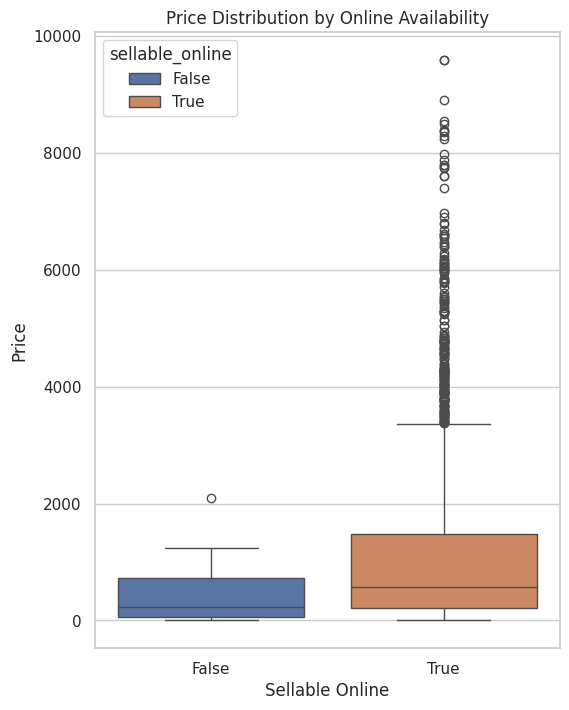

In [247]:
plt.figure(figsize=(6, 8))
sns.boxplot(x='sellable_online', y='price', data=df, hue = 'sellable_online');
plt.title('Price Distribution by Online Availability')
plt.xlabel('Sellable Online')
plt.ylabel('Price')
plt.show();

**3.1.1.Перевірка нормальності розподілу цін**

In [248]:
stat_online, p_online = normaltest(online_prices)
stat_offline, p_offline = normaltest(offline_prices)

print(f"Online prices normality test: Statistics={stat_online}, p-value={p_online}")
print(f"Offline prices normality test: Statistics={stat_offline}, p-value={p_offline}")

Online prices normality test: Statistics=1342.0173069983523, p-value=3.8427707469184743e-292
Offline prices normality test: Statistics=11.125354241123038, p-value=0.0038384865389215405


Проведемо перевірку на нормальність тестом Шапіро-Вілка.

In [252]:
statistic, p_value = shapiro(online_prices)
print("Shapiro-Wilk Test:")
print("Statistic:", statistic)
print("p-value:", p_value)

# Інтерпретація результатів
alpha = 0.05
if p_value > alpha:
    print("Розподіл є нормальним (не відхиляємо нульову гіпотезу)")
else:
    print("Розподіл не є нормальним (відхиляємо нульову гіпотезу)")


Shapiro-Wilk Test:
Statistic: 0.7302901744842529
p-value: 0.0
Розподіл не є нормальним (відхиляємо нульову гіпотезу)


In [253]:
statistic, p_value = shapiro(offline_prices)
print("Shapiro-Wilk Test:")
print("Statistic:", statistic)
print("p-value:", p_value)

# Інтерпретація результатів
alpha = 0.05
if p_value > alpha:
    print("Розподіл є нормальним (не відхиляємо нульову гіпотезу)")
else:
    print("Розподіл не є нормальним (відхиляємо нульову гіпотезу)")


Shapiro-Wilk Test:
Statistic: 0.7991176247596741
p-value: 0.001475958968512714
Розподіл не є нормальним (відхиляємо нульову гіпотезу)


Оскільки отримане p-value < 0.05, розподіл не є нормальним.Тож варто використовувати непараметричні тести, такі як Манн-Уїтні тест.

**3.1.2.t-тест для порівняння середніх**

In [249]:
t_stat, t_p_value = ttest_ind(online_prices, offline_prices, alternative='greater')

print(f"t-test: t-statistic={t_stat}, p-value={t_p_value}")

t-test: t-statistic=1.9212800574065885, p-value=0.027399350062044022


Отримали p-value  = 0.027, тож ми відхиляємо нульову гіпотезу.Отже середня ціна товарів, які не представлені онлайн, є нижчою за середню ціну товарів, які є в онлайн-продажу.

**3.1.3.Манн-Уїтні тест для порівняння медіан**

In [250]:
u_stat, u_p_value = mannwhitneyu(online_prices, offline_prices, alternative='greater')

print(f"Mann-Whitney U test: U-statistic={u_stat}, p-value={u_p_value}")

Mann-Whitney U test: U-statistic=33123.5, p-value=0.007302454765382354


Отримане p-value < 0.05, це вказує на те, що медіанні ціни товарів, які не представлені онлайн, є значно нижчими за медіанні ціни товарів, які є в онлайн-продажу.

Всі тести узгоджено показали p-value < 0.05,  це підтверджує альтернативну гіпотезу ($H_1$) про те, що товари, які не представлені онлайн, дійсно мають нижчі ціни.
Можливо припустити, що це залишки залежалого товару(або товару, який виводиться з асортименту), в обмеженій кількості які продаються зі знижкою лише в тих магазинах, де є в наявності, або пошкоджені та уцінені товари, чи товари з виставкової зали.

### **3.2.Формулювання гіпотези 2:**

- **Нульова гіпотеза ($H_0$)**: Медіанна ціна товарів дизайнерів IKEA of Sweden дорівнює медіанній ціні товарів інших дизайнерів у асортименті IKEA.

 - **Альтернативна гіпотеза ($H_1$)**: Медіанна ціна товарів дизайнерів IKEA of Sweden є нижчою за медіанну ціну товарів інших дизайнерів у асортименті IKEA.

Підготуємо дані для аналізу

Розділимо дані на дві групи: товари дизайнерів IKEA of Sweden та товари інших дизайнерів.

In [256]:
ikea_sweden_prices = df[df['designer_clean'] == 'IKEA of Sweden']['price']
other_designer_prices = df[df['designer_clean'] != 'IKEA of Sweden']['price']


In [258]:
print("Ikea_sweden statistics:")
print(ikea_sweden_prices.describe())
print("\nOther_designer prices statistics:")
print(other_designer_prices.describe())

Ikea_sweden statistics:
count    746.00000
mean     552.90000
std      701.74345
min        5.00000
25%       95.00000
50%      295.00000
75%      725.00000
max     4770.00000
Name: price, dtype: float64

Other_designer prices statistics:
count   2032.00000
mean    1314.78533
std     1524.19169
min        3.00000
25%      299.75000
50%      704.50000
75%     1742.50000
max     9585.00000
Name: price, dtype: float64


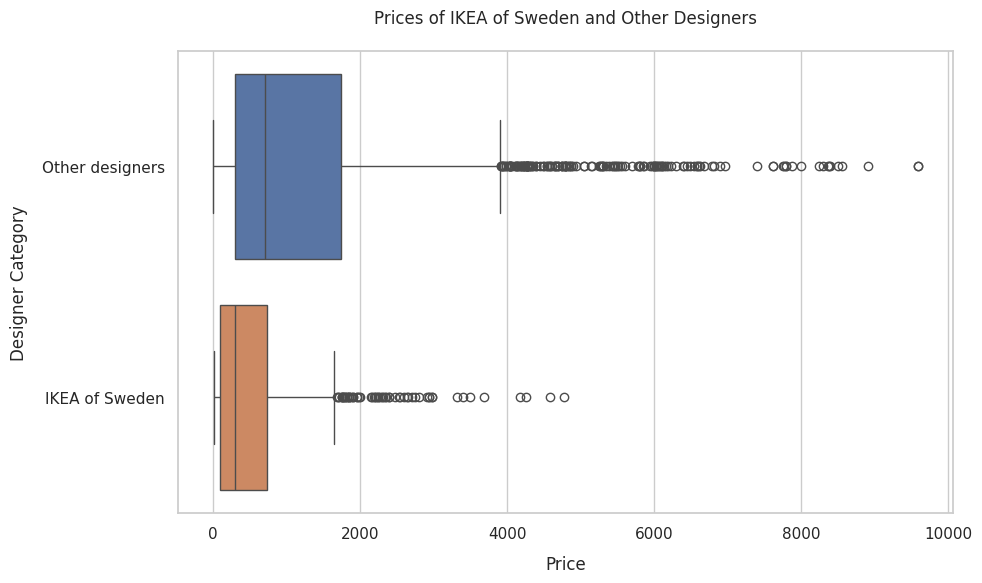

In [275]:
df['designer_category'] = df['designer_clean'].apply(lambda x: x if x == 'IKEA of Sweden' else 'Other designers')

plt.figure(figsize=(10, 6))
sns.boxplot(y='designer_category', x='price', hue='designer_category', data=df);
plt.title('Prices of IKEA of Sweden and Other Designers', pad = 20)
plt.ylabel('Designer Category', labelpad = 10)
plt.xlabel('Price', labelpad = 10)
plt.show();

**3.2.1.Перевірка нормальності розподілу цін:**

In [257]:
stat_sweden, p_sweden = normaltest(ikea_sweden_prices)
stat_other, p_other = normaltest(other_designer_prices)

print("IKEA of Sweden prices normality test: Statistics=", stat_sweden, "p-value=", p_sweden)
print("Other designers prices normality test: Statistics=", stat_other, "p-value=", p_other)

IKEA of Sweden prices normality test: Statistics= 385.0575425966929 p-value= 2.4311794577424598e-84
Other designers prices normality test: Statistics= 847.8039752341349 p-value= 7.974544944810034e-185


Проведемо перевірку на нормальність тестом Шапіро-Вілка.

In [ ]:
statistic, p_value = shapiro(ikea_sweden_prices)
print("Shapiro-Wilk Test for IKEA of Sweden prices:")
print("Statistic:", statistic)
print("p-value:", p_value)

In [ ]:
statistic, p_value = shapiro(other_designer_prices)
print("Shapiro-Wilk Test for other designers prices:")
print("Statistic:", statistic)
print("p-value:", p_value)

Оскільки отримане p-value < 0.05 в обох випадках, розподіл цін не є нормальним. Тому для аналізу використаємо непараметричні тести.

**3.2.2.Манн-Уїтні тест для порівняння медіан:**

In [259]:
u_stat, u_p_value = mannwhitneyu(ikea_sweden_prices, other_designer_prices, alternative='less')

print("Mann-Whitney U test for comparing medians:")
print("U-statistic:", u_stat)
print("p-value:", u_p_value)

Mann-Whitney U test for comparing medians:
U-statistic: 467442.5
p-value: 1.6163404932568943e-54


Отримане p-value < 0.05, що вказує на те, що медіанна ціна товарів дизайнерів IKEA of Sweden є значно нижчою за медіанну ціну товарів інших дизайнерів у асортименті IKEA. Це може свідчити про те, що товари дизайнерів IKEA of Sweden мають більш доступні ціни порівняно з іншими дизайнерами.

**3.2.3.Тест Краскела-Уолліса**

In [261]:
statistic, p_value = kruskal(ikea_sweden_prices, other_designer_prices)

print("Kruskal-Wallis test:")
print("Statistic:", statistic)
print("p-value:", p_value)

Kruskal-Wallis test:
Statistic: 240.39131160916892
p-value: 3.231338181926386e-54


Отримали p-value < 0.05, це підтверджує результати Манна-Уїтні тесту і підкріплює висновок про те, що медіанна ціна товарів дизайнерів IKEA of Sweden є нижчою за медіанну ціну товарів інших дизайнерів у асортименті IKEA.







## **4.Машинне навчання**
**Навчіть модель передбачати ціну меблів. Зазначте, які стовпці не слід включати до моделі і чому. Створіть конвеєр перехресної перевірки для навчання та оцінки моделі, включаючи (за необхідності) такі кроки, як заповнення пропущених значень та нормалізація. Запропонуйте методи покращення продуктивності моделі. Опишіть результати.**

### **4.1.Пошук найкращої моделі та найкращих параметрів**

На етапі EDA ми вже підготували дані для машинного навчання, а саме виключили непотрібні стовпці, такі як 'index', 'link' і 'item_id', оскільки вони не впливають на прогнозування ціни. Також очистили дані в колонці 'designer'.
Крім того виключили стовпець "old_price", оскільки він може спричинити проблеми мультиколінеарності(а також він мав 80% пропусків). Залишилось лише заповнити відсутні значення, але цей крок буде включено до pipeline.



Підготуємо дані для передачі в модель, а саме відокремимо таргет, та розділимо на навчальний та тренувальний набори даних.

In [206]:
X = df[['depth', 'width', 'height', 'category', 'designer_clean', 'other_colors']]
y = df['price']

Оскільки дані в розрізі категорій дуже різняться, важаю за потрібне зазначити параметр _stratify_, щоб забезпечити рівномірне потрапляння даних різних категорій у навчальний та тестовий дабір даних.

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['category'])

Підготуємо числові та категоріальні ознаки.

На етапі EDA було виявлено наявність пропусків в даних(габаритні розміри).

Створимо пайплайн для заповнення числових даних медіаною та їх скалювання, закодуємо категоріальні ознаки за допомогою _OneHotEncoder_.

In [208]:
numeric_features = ['depth', 'width', 'height']
categorical_features = ['category', 'designer_clean', 'other_colors']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

col_prepr = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
    ])


Функція для визначення кращої моделі навчання.

Функція автоматично запустить підготовчі кроки, які зазначені у пайплайні, проведе навчання, тестування, та поверне результати навчання(метрики _R^2_, _MAE_, _RMSE_)

In [209]:
def getBestRegressor(X_train, X_test, y_train, y_test):

    models = [
        LassoCV(),
        RidgeCV(),
        SVR(kernel='linear'),
        KNeighborsRegressor(n_neighbors=16),
        DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor(),
        BaggingRegressor(random_state=42),
        HistGradientBoostingRegressor(),
        xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
   ]

    TestModels = pd.DataFrame()
    res = {}
    tmp = {}

    for model in models:
        model_pipeline = Pipeline(steps=[
            ('col_prepr', col_prepr),
            ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
            ('model', model)
        ])

        m = str(model)
        tmp['Model'] = m[:m.index('(')]

        model_pipeline.fit(X_train, y_train)

        tmp['R^2'] = '{:.5f}'.format(model_pipeline.score(X_test, y_test))
        tmp['MAE'] = '{:.5f}'.format(mean_absolute_error(model_pipeline.predict(X_test), y_test))
        tmp['RMSE'] = '{:.5f}'.format(np.sqrt(mean_squared_error(model_pipeline.predict(X_test), y_test)))

        TestModels = pd.concat([TestModels, pd.DataFrame([tmp])])

    TestModels.set_index('Model', inplace=True)
    res['model'] = TestModels
    res['X_train'] = X_train
    res['y_train'] = y_train
    res['X_test'] = X_test
    res['y_test'] = y_test
    return res

Викличемо функцію для визначення кращої моделі та збережемо результати у датафрейм у відсортованому вигляді.

In [210]:
model = getBestRegressor(X_train, X_test, y_train, y_test)
model_info = model['model'].sort_values(by='R^2', ascending=False)
model_info[['R^2','MAE','RMSE']] = model_info[['R^2','MAE','RMSE']].astype(float)
model_info

,R^2,MAE,RMSE
Model,,,
XGBRegressor,0.78562,395.72214,672.55462
RandomForestRegressor,0.77465,388.35466,689.55823
HistGradientBoostingRegressor,0.75660,430.93678,716.63210
BaggingRegressor,0.75246,407.55568,722.70864
GradientBoostingRegressor,0.74679,465.34721,730.93585
RidgeCV,0.74002,501.16014,740.63637
KNeighborsRegressor,0.72820,447.95741,757.29716
LassoCV,0.71096,533.54026,780.93678
DecisionTreeRegressor,0.68471,498.19866,815.63632


Згідно отриманим результатам видно, що найкращі результати навчання показали 3 моделі, а саме: _XGBRegressor_, _RandomForestRegressor_  та _HistGradientBoostingRegressor_.

Візуалізація результатів

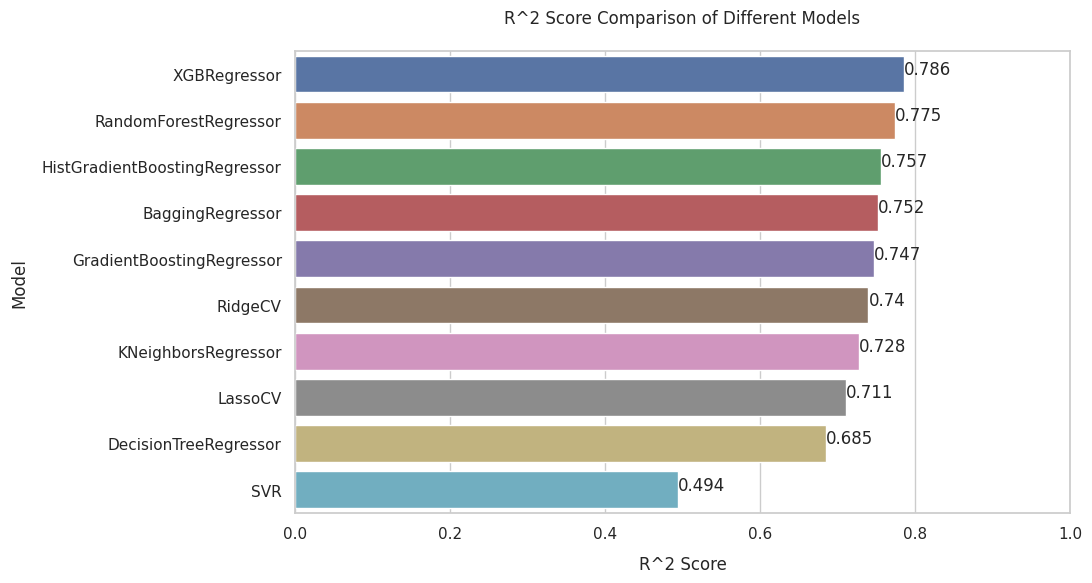

In [211]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='R^2', y='Model', data=model_info, hue='Model', orient='h');

for index, value in enumerate(model_info['R^2']):
    barplot.text(float(value), index, str(round(float(value), 3)))

plt.xlim(0,1)
plt.title('R^2 Score Comparison of Different Models',pad = 20)
plt.xlabel('R^2 Score', labelpad = 10)
plt.ylabel('Model', labelpad = 10)
plt.show();

Використаємо GridSearchCV для трьох найкращих моделей

In [212]:
top_models = model_info.head(3).reset_index()
top_models

,Model,R^2,MAE,RMSE
0,XGBRegressor,0.78562,395.72214,672.55462
1,RandomForestRegressor,0.77465,388.35466,689.55823
2,HistGradientBoostingRegressor,0.75660,430.93678,716.63210


In [213]:
# Параметри для GridSearchCV
top_models = top_models['Model']

param_grid = {
    'RandomForestRegressor': {
        'model__n_estimators': [10, 25, 50, 100, 150],
        'model__max_depth': [10, 20, 30, 40, None],
        'model__max_features': ['auto', 'sqrt', 'log2']
    },
    'HistGradientBoostingRegressor': {
        'model__max_iter': [100, 150, 200],
        'model__max_leaf_nodes': [10, 20, 30],
        'model__learning_rate': [0.01, 0.1, 0.2]
    },
    'XGBRegressor': {
        'model__n_estimators': [10, 25, 50, 100, 150],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

model_classes = {
    'RandomForestRegressor': RandomForestRegressor,
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor,
    'XGBRegressor': xgb.XGBRegressor
}

# Функція для GridSearchCV
def grid_search_cv(model, param_grid):
    pipeline = Pipeline(steps=[('col_prepr', col_prepr),
                               ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                               ('model', model)])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    return grid_search

# Виконання GridSearchCV для топ-3 моделей
best_models = {}

results_grid = pd.DataFrame(columns=['Model', 'R^2', 'MAE', 'RMSE','Best Parameters'])

for model_name in top_models:
    model_class = model_classes[model_name]
    grid_search = grid_search_cv(model_class(), param_grid[model_name])
    best_models[model_name] = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_models[model_name].predict(model['X_test'])

    results_grid = pd.concat([results_grid, pd.DataFrame({
        'Model': [model_name],
        'Best Parameters': [best_params],
        'R^2': [r2_score(model['y_test'], y_pred)],
        'MAE': [mean_absolute_error(model['y_test'], y_pred)],
        'RMSE': [np.sqrt(mean_squared_error(model['y_test'], y_pred))]
    })])

# Повернення датафрейму з результатами GridSearchCV
results_grid

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


,Model,R^2,MAE,RMSE,Best Parameters
0,XGBRegressor,0.78898,394.01436,667.26927,"{'model__learning_rate': 0.2, 'model__max_dept..."
0,RandomForestRegressor,0.77217,391.35734,693.33748,"{'model__max_depth': 40, 'model__max_features'..."
0,HistGradientBoostingRegressor,0.75779,433.83043,714.88660,"{'model__learning_rate': 0.1, 'model__max_iter..."


Підготуємо дані для візуалізації.

In [214]:
results_grid = results_grid[['Model','R^2', 'MAE', 'RMSE','Best Parameters']].reset_index()
results_grid

,index,Model,R^2,MAE,RMSE,Best Parameters
0,0,XGBRegressor,0.78898,394.01436,667.26927,"{'model__learning_rate': 0.2, 'model__max_dept..."
1,0,RandomForestRegressor,0.77217,391.35734,693.33748,"{'model__max_depth': 40, 'model__max_features'..."
2,0,HistGradientBoostingRegressor,0.75779,433.83043,714.88660,"{'model__learning_rate': 0.1, 'model__max_iter..."


 Візуалізація результатів GridSearchCV

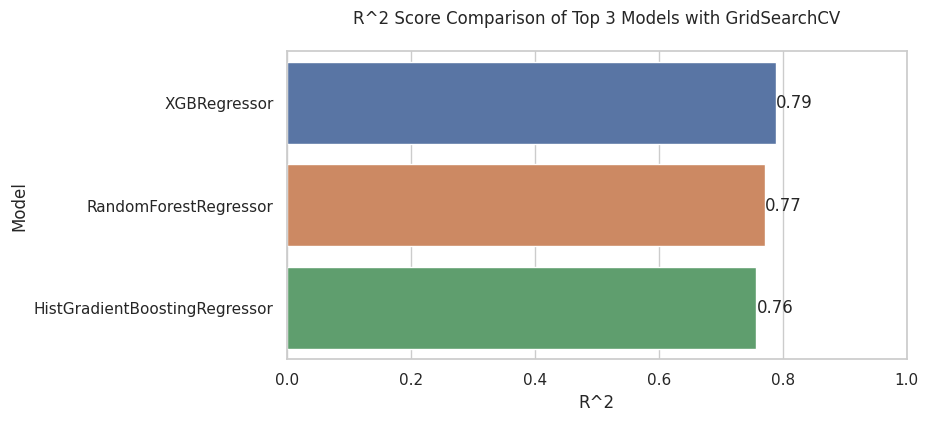

In [215]:
plt.figure(figsize=(8, 4))
sns.barplot(y='Model', x='R^2', data=results_grid, hue = 'Model');
for index, row in results_grid.iterrows():
    plt.text(row['R^2'], index, f"{row['R^2']:.2f}", va='center')

plt.xlim(0,1)
plt.title('R^2 Score Comparison of Top 3 Models with GridSearchCV', pad = 20)
plt.show();

### **4.2.Кросс-валідація топ-3 моделей машинного навчання**

Модель _xgb.XGBRegressor_

In [216]:
xgb_regr_param = results_grid['Best Parameters'][results_grid['Model'] == 'XGBRegressor'].iloc[0]
xgb_regr_param = {str(key): value for key, value in xgb_regr_param.items()}
xgb_regr_param

xgb_regr = xgb.XGBRegressor(**xgb_regr_param)

xgb_pipeline = Pipeline(steps=[
    ('col_prepr', col_prepr),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('model', xgb_regr)
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
score_xgb_regr = cross_val_score(xgb_pipeline, X, y, scoring='r2', cv=cv)


res_xgb_regr = pd.DataFrame({
    'Model': 'XGBRegressor',
    'Metric': 'R^2',
    'Cross-Validation Scores': score_xgb_regr
})
res_xgb_regr


,Model,Metric,Cross-Validation Scores
0,XGBRegressor,R^2,0.76731
1,XGBRegressor,R^2,0.82803
2,XGBRegressor,R^2,0.78499
3,XGBRegressor,R^2,0.78312
4,XGBRegressor,R^2,0.83012


Коливання точності моделі _XGBRegressor_




In [217]:
max_score = res_xgb_regr['Cross-Validation Scores'].max()
min_score = res_xgb_regr['Cross-Validation Scores'].min()
xgb_dif = (max_score - min_score)*100
xgb_dif

6.280969798860758

Візуалізація результатів навчання _XGBRegressor_

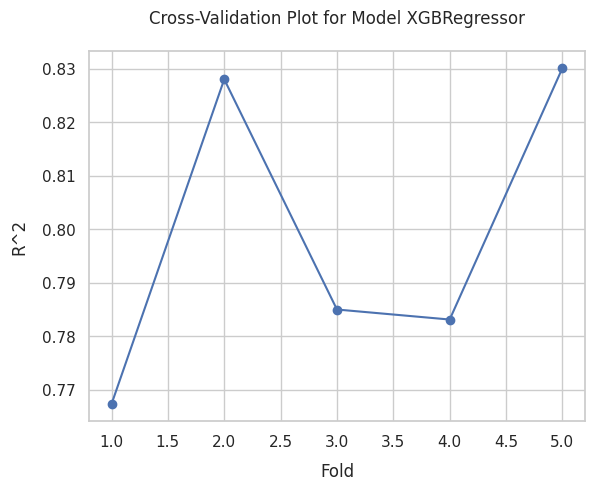

In [218]:
plt.plot(range(1, len(score_xgb_regr)+1),score_xgb_regr, marker = 'o');
plt.xlabel('Fold', labelpad = 10)
plt.ylabel('R^2', labelpad = 10)
plt.title('Cross-Validation Plot for Model XGBRegressor',pad = 20)
plt.show();

Модель _RandomForestRegressor_

In [219]:
rf_results = results_grid[results_grid['Model'] == 'RandomForestRegressor'].iloc[0]
rf_regr_param = rf_results['Best Parameters']
rf_regr_param = {key.replace('model__', ''): value for key, value in rf_regr_param.items()}
rf_regr_param

rf_regr = RandomForestRegressor(**rf_regr_param)

rf_pipeline = Pipeline(steps=[
    ('col_prepr', col_prepr),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('model', rf_regr)
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
score_rf_regr = cross_val_score(rf_pipeline, X, y, scoring='r2', cv=cv)


res_rf_regr = pd.DataFrame({
    'Model': 'RandomForestRegressor',
    'Metric': 'R^2',
    'Cross-Validation Scores': score_rf_regr
})
res_rf_regr

,Model,Metric,Cross-Validation Scores
0,RandomForestRegressor,R^2,0.74748
1,RandomForestRegressor,R^2,0.80265
2,RandomForestRegressor,R^2,0.79058
3,RandomForestRegressor,R^2,0.77244
4,RandomForestRegressor,R^2,0.80804


Коливання точності моделі  _RandomForestRegressor_


In [220]:
max_score = res_rf_regr['Cross-Validation Scores'].max()
min_score = res_rf_regr['Cross-Validation Scores'].min()
rf_dif = (max_score - min_score)*100
rf_dif

6.056021862465444

Візуалізація результатів навчання  _RandomForestRegressor_

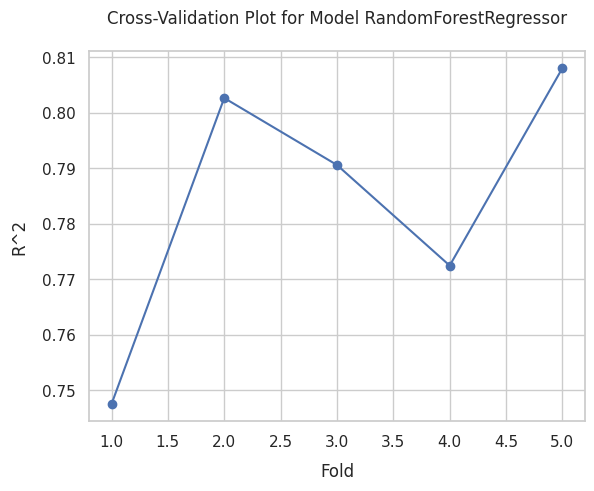

In [221]:
plt.plot(range(1, len(score_rf_regr)+1), score_rf_regr, marker = 'o');
plt.xlabel('Fold', labelpad = 10)
plt.ylabel('R^2', labelpad = 10)
plt.title('Cross-Validation Plot for Model RandomForestRegressor',pad = 20)
plt.show();

Модель  _HistGradientBoostingRegressor_

In [222]:
hgb_regr_param = results_grid['Best Parameters'][results_grid['Model'] == 'HistGradientBoostingRegressor'].iloc[0]
hgb_regr_param = {str(key): value for key, value in hgb_regr_param.items()}
hgb_regr_param = {key.replace('model__', ''): value for key, value in hgb_regr_param.items()}
hgb_regr_param

hgb_regr = HistGradientBoostingRegressor(**hgb_regr_param)

hgb_pipeline = Pipeline(steps=[
    ('col_prepr', col_prepr),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('model', hgb_regr)
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
score_hgb_regr = cross_val_score(hgb_pipeline, X, y, scoring='r2', cv=cv)


res_hgb_regr = pd.DataFrame({
    'Model': 'HistGradientBoostingRegressor',
    'Metric': 'R^2',
    'Cross-Validation Scores': score_hgb_regr
})
res_hgb_regr

,Model,Metric,Cross-Validation Scores
0,HistGradientBoostingRegressor,R^2,0.73071
1,HistGradientBoostingRegressor,R^2,0.81543
2,HistGradientBoostingRegressor,R^2,0.77151
3,HistGradientBoostingRegressor,R^2,0.75263
4,HistGradientBoostingRegressor,R^2,0.81096


Коливання точності моделі _XGBRegressor_

In [223]:
max_score = res_hgb_regr['Cross-Validation Scores'].max()
min_score = res_hgb_regr['Cross-Validation Scores'].min()
hgb_dif = (max_score - min_score)*100
hgb_dif

8.471609484400178

Візуалізація результатів навчання  _HistGradientBoostingRegressor_

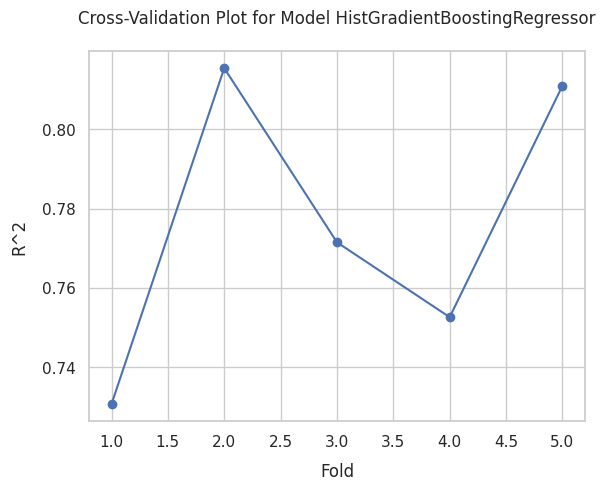

In [224]:
plt.plot(range(1, len(score_hgb_regr)+1), score_hgb_regr, marker = 'o');
plt.xlabel('Fold', labelpad = 10)
plt.ylabel('R^2', labelpad = 10)

plt.title('Cross-Validation Plot for Model HistGradientBoostingRegressor',pad = 20)
plt.show();

Подивимось графік порівняння кросс-валідації топ-3 моделей

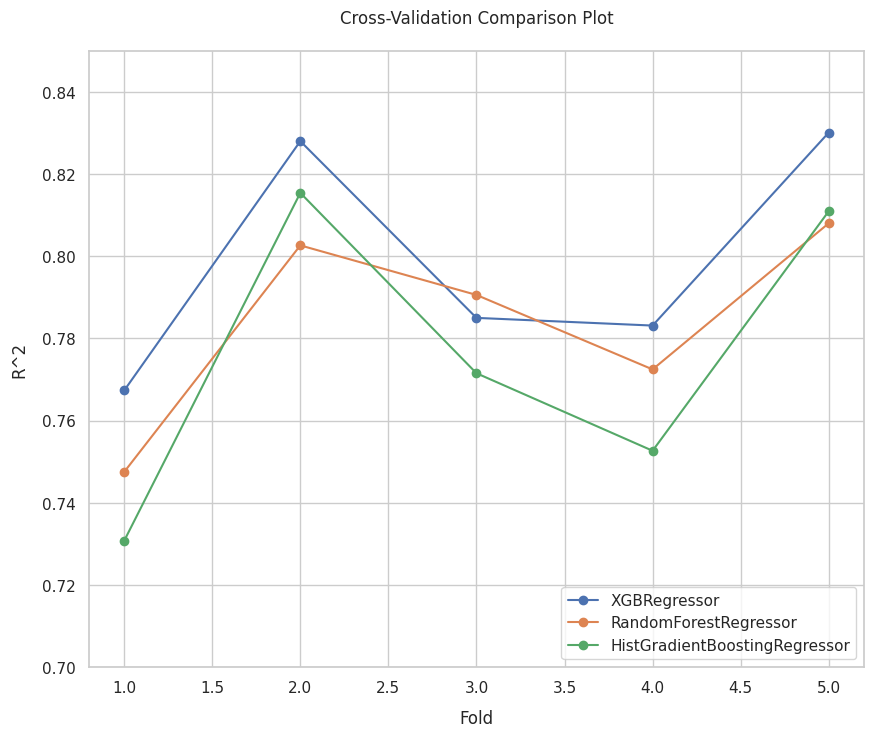

In [225]:
plt.figure(figsize = (10,8))
plt.plot(range(1, len(score_xgb_regr)+1),score_xgb_regr, marker = 'o', label = 'XGBRegressor');
plt.plot(range(1, len(score_rf_regr)+1), score_rf_regr, marker = 'o', label = 'RandomForestRegressor');
plt.plot(range(1, len(score_hgb_regr)+1), score_hgb_regr, marker = 'o', label = 'HistGradientBoostingRegressor');
plt.title('Cross-Validation Comparison Plot', pad = 20)
plt.xlabel('Fold', labelpad = 10)
plt.ylabel('R^2', labelpad = 10)
plt.ylim(0.7,0.85)
plt.legend(loc='lower right')
plt.show();

Подивимось на стабільність топ-3 моделей навчання

In [226]:
models = ['XGBRegressor', 'RandomForestRegressor', 'HistGradientBoostingRegressor']
stabilities = [(100-xgb_dif), (100-rf_dif), (100-hgb_dif)]
stability = pd.DataFrame({
    'model': models,
    'stability': stabilities
})
stability = stability.sort_values('stability', ascending= False).reset_index()
stability

,index,model,stability
0,1,RandomForestRegressor,93.94398
1,0,XGBRegressor,93.71903
2,2,HistGradientBoostingRegressor,91.52839


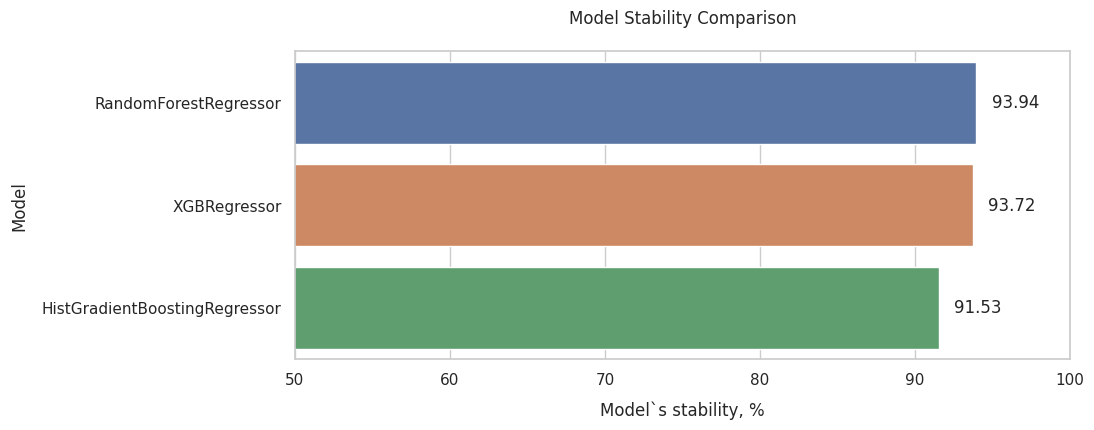

In [227]:
plt.figure(figsize = (10,4))
sns.barplot(y = 'model', x = 'stability', data =stability, hue = 'model');
for index, row in stability.iterrows():
    plt.text(row['stability']+1, index, f"{row['stability']:.2f}", va='center')
plt.xlim(50,100)
plt.xlabel('Model`s stability, %', labelpad = 10)
plt.ylabel('Model', labelpad = 10)
plt.title('Model Stability Comparison', pad = 20)
plt.show();

В цьому розділі було використано широкий спектр моделей для навчання. Після чого було визначено топ-3 моделей, які були передані у GridSearchCV для вибору найкращих параметрів. Потім було перевірено їх продуктивність за допомогою крос-валідації.

Результати показують, що моделі XGBRegressor, RandomForestRegressor та HistGradientBoostingRegressor демонструють найкращі показники R^2 під час крос-валідації із найкращими параметрами.

Стабільність моделей також підтверджує їх надійність. Хоча спостерігаються деякі варіації у показниках R^2 , проте загальна стабільність показників є задовільною.

Порівнявши результати моделей, ми бачимо, що XGBRegressor має найвищий середній показник R^2, а RandomForestRegressor і HistGradientBoostingRegressor мають трохи менший, але все ще прийнятний, рівень точності.

Незважаючи на добрі показники, є можливості для подальшого поліпшення моделей. Наприклад:
 - дослідження ширшого діапазону значень параметрів;
 - створення ансамблевих моделей, які поєднують кілька найкращих моделей разом для отримання більш точних прогнозів;
 - тестування різного процентного розподілу даних для навчання та тестування;
 - збільшення об'єму даних.